# **Introduction to Deep Learning -- Classification**

<img src="https://incubator.ucf.edu/wp-content/uploads/2023/07/artificial-intelligence-new-technology-science-futuristic-abstract-human-brain-ai-technology-cpu-central-processor-unit-chipset-big-data-machine-learning-cyber-mind-domination-generative-ai-scaled-1-1500x1000.jpg" width="600"/>


<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2025/blob/main/practicals/ML_Foundation/Part_2/Machine_learning_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


© Deep Learning Indaba 2025. Apache License 2.0.

**Authors:** Tinuade Adeleke

**Reviewers:** Ulrich Mbou Sob

**Introduction:**
In machine learning, classification is a fundamental supervised learning task where the goal is to assign a label or category to an input based on learned patterns from a labeled dataset. For instance, a model may learn to classify emails as "spam" or "not spam" based on features like subject line, word usage, and sender address. Classification problems can be binary (two classes) or multiclass (more than two categories), and they are central to many real-world applications such as disease diagnosis, image recognition, fraud detection, and sentiment analysis. The learning algorithm is trained on a dataset where each example is paired with a correct label, and the objective is to learn a decision boundary or rule that generalizes well to unseen data. Logistic regression, decision trees, support vector machines, and neural networks are some of the common machine learning algorithms used for classification tasks.

In this tutorial, we explore how logistic regression and neural networks can be used to solve classification problems. We'll start by understanding the core ideas behind classification and implementing a simple logistic regression classifier from scratch. We'll look at logistic regression for non linear datasets. Finally, we’ll build a binary classifier using a multilayer perceptron (MLP) in JAX, and then extend it to handle multiclass classification.


**Topics:**

Content: <font color='green'>`Classification`</font> , <font color='orange'>`Supervised Learning`</font>  
Level: <font color='grey'>`Beginner`</font>


**Aims/Learning Objectives:**

By the end of this tutorial, you will be able to:

- Understand the fundamental concepts and goals of classification in machine learning.

- Grasp the intuition behind logistic regression and how it connects to other classification algorithms.

- Implement multilayer perceptrons (MLPs) for classification tasks using JAX.

- Train MLPs effectively and evaluate their performance on real-world data.

**Prerequisites:**

- Practical 1
  - Regression
  - Basic knowledge of Jax

**Outline:**

>[Part 1 - Logistic regression](#scrollTo=8Ewv4SrHFlQk)

>>[Limitations of linear regression](#scrollTo=68t383ohGJr2)

>>[Sigmoid function](#scrollTo=61Dp91ogni5w)

>>[Loss landscape visualisation](#scrollTo=IIn9Cak2Gcq7)

>>[Cross-Entropy Loss function derivation](#scrollTo=s5esOI7qpZQ9)

>>[Non linear models](#scrollTo=YlCwAggVgXZU)

>[Part 2 - Build a simple binary classifier with JAX](#scrollTo=HnPYinQxGujS)

>>[Define a Multi-Layer Perceptron in JAX](#scrollTo=vYdRBTYUb6dt)

>>[Evaluation Metrics](#scrollTo=XhoxOrTaGK4u)

>>>[Accuracy](#scrollTo=y6CnSfqlN4Hc)

>>>[Precision](#scrollTo=D__Ebo1sTOSa)

>>>[Recall](#scrollTo=5i0qVBmzTUf2)

>>[Write a training loop](#scrollTo=Ex3XXNopcjPY)

>[Part 3 - Multi-Class Classifier](#scrollTo=jjPqryMaHIie)

>>[Load MNIST Dataset](#scrollTo=adol9O47d72s)

>>[Modify Binary MLP](#scrollTo=cchEO81Ud90J)

>>[Softmax Cross Entropy Loss](#scrollTo=XRj4fyPQedmx)

>[Appendix:](#scrollTo=8dmPgHGhH8oU)

**Note:** To get the most out of this tutorial, try answering the questions, quizzes, and code tasks on your own before checking the solutions. Actively working through them is the most effective way to learn.

**Before you start:**

Run the "Installation and Imports" cell below.

### Installation and Imports

In [1]:
!pip install jax flax optax clu --quiet

import numpy as np
import random
import matplotlib.pyplot as plt
from flax import nnx
import jax
import jax.numpy as jnp
import pandas as pd
import copy
import math
from matplotlib import cm
import tensorflow as tf
import optax
import flax
from clu import metrics
from flax import struct
import tensorflow_datasets as tfds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 5.5 MB/s eta 0:00:00


#### Helper functions (Run Cell)

In [3]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))
sigmoid

<function __main__.<lambda>(x)>

In [2]:
def log_1pexp(x, maximum=20):
    ''' approximate log(1+exp^x)
        https://stats.stackexchange.com/questions/475589/numerical-computation-of-cross-entropy-in-practice
    Args:
    x   : (ndarray Shape (n,1) or (n,)  input
    out : (ndarray Shape matches x      output ~= np.log(1+exp(x))
    '''

    out  = np.zeros_like(x,dtype=float)
    i    = x <= maximum
    ni   = np.logical_not(i)

    out[i]  = np.log(1 + np.exp(x[i]))
    out[ni] = x[ni]
    return out


In [4]:
def compute_cost_matrix(X, y, w, b, logistic=False, lambda_=0, safe=True):
    m = X.shape[0]
    y = y.reshape(-1,1)             # ensure 2D
    w = w.reshape(-1,1)             # ensure 2D
    if logistic:
        if safe:  #safe from overflow
            z = X @ w + b                                                           #(m,n)(n,1)=(m,1)
            cost = -(y * z) + log_1pexp(z)
            cost = np.sum(cost)/m                                                   # (scalar)
        else:
            f    = sigmoid(X @ w + b)                                               # (m,n)(n,1) = (m,1)
            cost = (1/m)*(np.dot(-y.T, np.log(f)) - np.dot((1-y).T, np.log(1-f)))   # (1,m)(m,1) = (1,1)
            cost = cost[0,0]                                                        # scalar
    else:
        f    = X @ w + b                                                        # (m,n)(n,1) = (m,1)
        cost = (1/(2*m)) * np.sum((f - y)**2)                                   # scalar

    reg_cost = (lambda_/(2*m)) * np.sum(w**2)                                   # scalar

    total_cost = cost + reg_cost                                                # scalar

    return total_cost                                                           # scalar


In [5]:
def compute_gradient(x, y, y_hat, w, b):
    m = x.shape[0]

    err   = y_hat - y                                              # (m,1)
    dj_dw = (1/m) * (x.T @ err)                                   # (n,m)(m,1) = (n,1)
    dj_db = (1/m) * np.sum(err)                                   # scalar

    return dj_db, dj_dw                                           # scalar, (n,1)

In [6]:
def gradient_descent(X, y, w_in, b_in, alpha, num_iters, logistic=False, lambda_=0, verbose=True):

    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    w = w.reshape(-1,1)      #prep for matrix operations
    y = y.reshape(-1,1)

    for i in range(num_iters):

        if logistic:
            f_wb  = sigmoid( X @ w + b )
        else:
            f_wb  = X @ w + b

        # f_wb  = sigmoid( X @ w + b ) if logistic else  X @ w + b

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = compute_gradient(X, y, f_wb, w, b)

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion
            J_history.append( compute_cost_matrix(X, y, w, b, logistic, lambda_) )

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            if verbose: print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")
    return w.reshape(w_in.shape), b
    # return w.reshape(w_in.shape), b, J_history  #return final w,b and J history for graphing

In [7]:
'''
Let's plot our dataset with the different classes highlighted in different colors
'''
def plot_data(x, y, w=np.zeros((1)), b=0.0, thresh=None, logistic=False):
  plt.scatter(x, y, c=y, cmap="rainbow")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.title("Dataset")

  if w.item() != 0:
    x_line = np.linspace(min(x), max(x), 100)
    if logistic:
      print('using logistic regression')

      y_line = sigmoid(np.matmul(x_line.reshape(-1,1), w.reshape(-1,1)) + b)
    else:
      y_line = np.matmul(x_line.reshape(-1,1), w.reshape(-1,1)) + b

    plt.plot(x_line, y_line, color="green", label=r"$f_{w,b}(x) = wx + b$")

    if thresh is not None:
      if len(thresh) == 1:
        plt.axhline(y=thresh[0], color="black", linestyle="--", label=f"Threshold = {thresh[0]}")
      elif len(thresh) == 2:
        plt.axhline(y=thresh[1], color="purple", linestyle="--", label=f"Threshold = {thresh[1]}")
        plt.axvline(x=thresh[0], color="black", linestyle="--", label=f"Threshold = {thresh[0]}")
  plt.grid(True)
  plt.show()

In [8]:
def compute_cost_logistic_sq_err(X, y, w, b):
    """
    compute sq error cost on logicist data (for negative example only, not used in practice)
    Args:
      X (ndarray): Shape (m,n) matrix of examples with multiple features
      w (ndarray): Shape (n)   parameters for prediction
      b (scalar):              parameter  for prediction
    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]
    cost = 0.0
    for i in range(m):
        z_i = np.dot(X[i],w) + b
        f_wb_i = sigmoid(z_i)                 #add sigmoid to normal sq error cost for linear regression
        cost = cost + (f_wb_i - y[i])**2
    cost = cost / (2 * m)
    return np.squeeze(cost)

In [9]:
def plt_logistic_squared_error(X, y, cost_function):
    """ plots logistic squared error for demonstration """
    wx, by = np.meshgrid(np.linspace(-6,12,50),
                         np.linspace(10, -20, 40))
    points = np.c_[wx.ravel(), by.ravel()]
    cost = np.zeros(points.shape[0])

    for i in range(points.shape[0]):
        w,b = points[i]
        cost[i] = cost_function(X.reshape(-1,1), y, w, b)
    cost = cost.reshape(wx.shape)

    fig = plt.figure()
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.plot_surface(wx, by, cost, alpha=0.6,cmap=cm.jet,)

    ax.set_xlabel('w', fontsize=16)
    ax.set_ylabel('b', fontsize=16)
    ax.set_zlabel("Cost", rotation=90, fontsize=16)
    ax.set_title('"Logistic" Squared Error Cost vs (w, b)')
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

In [10]:
def plt_logistic_cost(X, y, cost_function):
    """ plots logistic cost """
    wx, by = np.meshgrid(np.linspace(-6,12,50),
                         np.linspace(0, -20, 40))
    points = np.c_[wx.ravel(), by.ravel()]
    cost = np.zeros(points.shape[0],dtype=np.longdouble)

    for i in range(points.shape[0]):
        w,b = points[i]
        cost[i] = cost_function(X.reshape(-1,1), y, w, b, logistic=True, safe=True)
    cost = cost.reshape(wx.shape)

    fig = plt.figure(figsize=(9,5))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_surface(wx, by, cost, alpha=0.6,cmap=cm.jet,)

    ax.set_xlabel('w', fontsize=16)
    ax.set_ylabel('b', fontsize=16)
    ax.set_zlabel("Cost", rotation=90, fontsize=16)
    ax.set_title('Logistic Cost vs (w, b)')
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    ax = fig.add_subplot(1, 2, 2, projection='3d')

    ax.plot_surface(wx, by, np.log(cost), alpha=0.6,cmap=cm.jet,)

    ax.set_xlabel('w', fontsize=16)
    ax.set_ylabel('b', fontsize=16)
    ax.set_zlabel('\nlog(Cost)', fontsize=16)
    ax.set_title('log(Logistic Cost) vs (w, b)')
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    plt.show()
    return cost

In [11]:
def reset_matplotlib():
    %matplotlib inline
    plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'

reset_matplotlib()

In [12]:
from flax.core import freeze, unfreeze

# Recursively print all parameter names and their shapes
def print_param_shapes(params, prefix=""):
    for key, val in params.items():
        if isinstance(val, dict):
            print_param_shapes(val, prefix=f"{prefix}{key}/")
        else:
            print(f"{prefix}{key}: shape={val.shape}")

In [13]:
@struct.dataclass
class BinaryAccuracy(metrics.Average):
  """Computes the recall from model outputs `logits` and `labels`."""

  @classmethod
  def from_model_output(cls, *, logits: jnp.array, labels: jnp.array, **kwargs) -> metrics.Metric:
    assert logits.shape[-1] == 1, "Expected binary logits."
    logits = jnp.array(logits)
    metrics = super().from_model_output(values=((logits > 0.5).astype(int) == labels), **kwargs)
    return cls(**vars(metrics))

In [14]:
def plot_decision_boundary(X, model, render=True):
    """Overlays the classifier's decision boundary on the dataset [X, y].

    Args:
        X: 2-d matrix input data,
        model: The model to evaluate
    """

    step_size = 0.02    # Discretization step-size

    # Get the boundaries of the dataset.
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # Generate a grid of points, step_size apart, over the above region.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size),
                                             np.arange(y_min, y_max, step_size))

    # Flatten the data and get the logits of the classifier (the "scores") for
    #     each point in the generated mesh-grid.
    meshgrid_matrix = np.c_[xx.ravel(), yy.ravel()]
    Z = model.get_logits(meshgrid_matrix)

    # Get the class predictions for each point.
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)

    old_backend = plt.rcParams['backend']    # Save backend.
    if not render:
        plt.rcParams['backend'] = 'agg'

    # Overlay both of these on one figure.
    fig = plt.figure()
    axes = plt.gca()

    axes.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    axes.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    if not render:
        # Now we can save it to a numpy array.
        fig.tight_layout(pad=0)
        fig.canvas.draw()
        data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        # Restore old backend
        plt.rcParams['backend'] = old_backend

        return data

    #fig.savefig('spiral_linear.png')

In [15]:
def softmax(logits):
    """Convert un-normalised model scores(logits) into a probability distribution.

    Args:
        logits: The un-normalised scores assigned by the model.
    """
    exp_logits = np.exp(logits)
    # Notice this trick for numerical stability.
    #exp_logits -= np.max(exp_logits)
    probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    return probs



In [16]:
def cross_entropy(predictions, targets):
    """Calculate the cross entropy loss given some predictions and target (true) values.

    Args:
        predictions: The model predictions (of shape [num_examples, num_classes])
        targets: The correct labels for the data (of shape [num_examples])
    """
    num_examples = predictions.shape[0]

    # NOTE: xent(pred, trgt) = -sum_i p_trgt[i] * log(pred[i]). But since we
    # use one-hot encodings for p_trgt[i], it means all p_trgt[i] are zero
    # except for the observed class. We therefore only compute the logs of the
    # predictions of the observed classes below. To do that, we use advanced
    # indexing X[[0, 1, 2, 3, ..., num_examples], target_ids] which extracts the
    # predicted log-prob for the correct target class (target_ids) for each example.
    # QUESTION: Can you see why this works? Lookup "advanced indexing" if unsure.
    correct_logprobs = -np.log(predictions[range(num_examples), targets])

    # NOTE: When dealing with a batch of data, we compute the average cross
    # entropy over the batch (i.e. we want the average per-example loss).
    # QUESTION: Why do we use the average loss?
    crossentropy = np.sum(correct_logprobs) / num_examples
    return crossentropy



In [17]:
def l2_loss(parameters):
    """Calculate the L2 regularisation of a list of parameters."""
    reg = 0.0
    for param in parameters:
        reg += 0.5 * reg_lambda * np.sum(param * param)
    return reg

In [18]:
def generate_spiral_data(num_classes, dimensions, points_per_class):
    """Generate `num_classes` spirals with `points_per_class` points per spiral."""

    x = np.zeros((points_per_class*num_classes, dimensions), dtype='float32')    # Create an empty matrix to hold our X values
    y = np.zeros(points_per_class*num_classes, dtype='uint8')    # Create an empty vector to hold our y values
    radius = 0.5

    for y_value in range(num_classes):     # Generate data for each class
        ix = range(points_per_class*y_value, points_per_class*(y_value+1))    # The indices in X and y where we will save this class of data
        radius = np.linspace(0.0, 1, points_per_class)    # Generate evenly spaced numbers in the interval 0 to 1
        theta = np.linspace(y_value*4, (y_value+1)*4, points_per_class) + np.random.randn(points_per_class) * 0.2

        x[ix] = np.column_stack([radius*np.sin(theta), radius*np.cos(theta)])     # Convert polar coordinates to standard Euclidian coordinates
        y[ix] = y_value

    return x, y


def plot_spiral_data(x, y):
    """Use Matplotlib to plot X, y data on a figure."""
    fig = plt.figure()
    plt.scatter(x[:, 0], x[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return fig

## Logistic Regression

In this section we would build the intuition for logistic regression and build a logistic regression classifier from scratch. Some helper functions for plotting and other things have been provided below so you should just run the cells.

#### Limitations of Linear regression


In the previous tutorial, we used non linear regression to solve a numerical prediction task and saw how effective it can be in that context. However, as mentioned in the introduction, many real-world machine learning problems involve classification, where the goal is to assign a discrete label or category to an input.

This naturally raises the question: **Can linear regression be used for classification tasks?** That’s what we’ll explore in this section. If it works, why does it work? If it doesn’t, what are the limitations?

To investigate, we’ll apply linear regression to a simple classification problem. We’ll use a dataset where each record contains the number of hours a student studied and whether they passed (1) or failed (0) an exam. The aim is to train a model that can predict whether a student will pass based on the number of hours studied. We’ll intentionally keep the dataset small so that we can observe, manipulate, and reason about the model’s behavior in a controlled setting.

<details>
<summary>🔬 Note</summary>
This kind of hands on, iterative exploration posing questions, designing simple experiments, observing outcomes, and refining your understanding is exactly how scientists and researchers approach new problems. It’s not just about finding the right answer, but about learning why an approach works or doesn’t work, and using that insight to guide better solutions.
</details>

Run the cell below to visualize the dataset we would work with

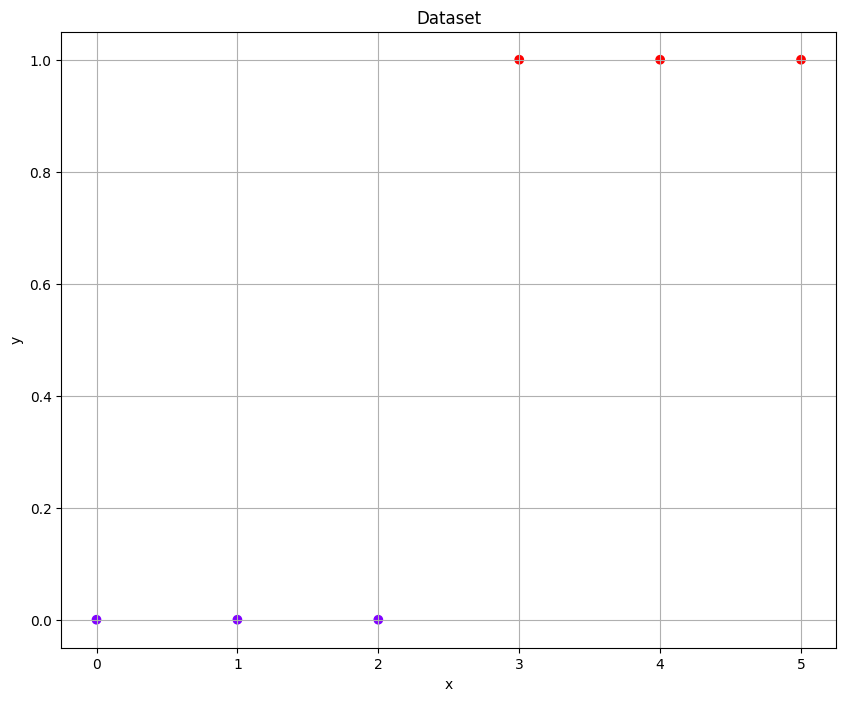

In [20]:
hours = np.array([0, 1, 2, 3, 4, 5])
passed = np.array([0, 0, 0, 1, 1, 1])
plot_data(hours, passed)

❓**Question**: Given the objective function used in linear regression, what kind of decision boundary do you expect the model to learn for predicting whether a student passes or fails based on hours studied?

<details>
<summary>✅ Answer</summary>
Linear regression tries to minimize the squared error between the predicted value and the true value using the objective function:

$$
\
L(\mathbf{w}, b) = \frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2
\
$$

It sees the labels in y as just another numerical value.

We have 3 data points labeled 0 (at x = 0, 1, 2)

We have 3 data points labeled 1 (at x = 3, 4, 5)

The model in theory will try to learn a regression line with slope and intercept that make the predictions close to 0 for x = 0, 1, 2 and close to 1 for x = 3, 4, 5. We'll see if this is actually the case.
</details>

**💻 Code Task: Implement Gradient Descent for Linear Regression**

Your task is to implement a function `gradient_decent` that performs linear regression on the dataset above and returns the final model parameters:`w` (weight) and `b` (bias).

To help you, a helper function named `compute_gradient` has been provided. It takes in:
- `x`: the input features,
- `y`: the corresponding labels,
- `y_hat`: the output of the model
- `w`, `b`: the current model parameters,

It returns:
- `dj_db`: the gradient of the loss with respect to the bias (scalar),

- `dj_dw`: the gradient of the loss with respect to the weights (shape: (n, 1))

The function internally calculates the error between the model's predictions and the true labels, then computes how each parameter should be adjusted to reduce this error.

Example usage:
```python
dj_db, dj_dw = compute_gradient_matrix(x, y, y_hat, w, b)
```

Inside your `gradient_decent` function:

1. Compute the output of the model
2. Use the `compute_gradient` function to compute the gradients of the loss with respect to `w` and `b`.
3. Use those gradients to update the model parameters using gradient descent.
4. Repeat this for `num_iters` steps.
5. Return the final values of `w` and `b`.

In [21]:
def gradient_descent(x, y, w_in, b_in, alpha, num_iters):
  """
    Performs gradient descent to optimize the parameters of a linear regression model.

    Parameters:
    ----------
    x : np.ndarray
        Input features of shape (n_samples, 1).
    y : np.ndarray
        Target labels of shape (n_samples, 1).
    w_in : np.ndarray
        Initial weight parameter of the model of shape (1, 1).
    b_in : float
        Initial bias parameter of the model.
    alpha : float
        Learning rate that controls the step size in each iteration.
    num_iters : int
        Number of iterations to run the gradient descent loop.

    Returns:
    -------
    w : np.ndarray
        Optimized weight parameter of shape (1).
    b : float
        Optimized bias parameter.
  """

  # Initialize parameters
  w = w_in
  b = b_in

  for i in range(num_iters):
    # make a prediction
    y_hat = x @ w + b

    # calculate gradient
    dj_db, dj_dw = compute_gradient(x,y,y_hat,w,b)

    # update parameters w and b
    w = w - alpha * dj_dw
    b = w - alpha * dj_db
  return w, b


<details>
<summary>💡Hint</summary>

- Use the learning rate alpha to control how large your updates are. The basic update rule is:

```python
w = w - alpha * grad_w  
b = b - alpha * grad_b
```

- Use `w.reshape(1)` to return `w` as a 1d array.
</details>

🧪 Test your code

In [22]:
def test_gradient_descent():
  hours = np.array([0, 1, 2, 3, 4, 5]).reshape(-1, 1)
  passed = np.array([0, 0, 0, 1, 1, 1]).reshape(-1, 1)
  w = np.zeros((1)).reshape(-1, 1)
  b = 0.0
  alpha = 0.01
  num_iters = 10
  w, b = gradient_descent(hours, passed, w, b, alpha, num_iters)
  assert w != 0.0
  assert b != 0.0
  y = w*2 + b
  assert y < 0.5
  print("Test passed!")

test_gradient_descent()

Test passed!


In [23]:
# @title 🔓Solution - Gradient descent (Try not to peek until you've given it a good try!')
def gradient_descent(x, y, w_in, b_in, alpha, num_iters):
    w = w_in
    b = b_in

    for i in range(num_iters):

        y_hat  =  x @ w + b

        # Calculate the gradient
        dj_db,dj_dw = compute_gradient(x, y, y_hat, w, b)

        # Update Parameters using w, b, alpha and gradient
        w = w - (alpha * dj_dw)
        b = b - (alpha * dj_db)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: w: {w.item()}, b: {b}")

    return w.reshape(w_in.shape), b

In [26]:
hours = np.array([0, 1, 2, 3, 4, 5]).reshape(-1, 1)
passed = np.array([0, 0, 0, 1, 1, 1]).reshape(-1, 1)
w = np.zeros((1)).reshape(-1, 1)
b = 0.0
alpha = 0.01
num_iters = 1000
print(f"Start: w = {w.item()}, b = {b:.3f}")
w1, b1 = gradient_descent(hours, passed, w, b, alpha, num_iters)

Start: w = 0.0, b = 0.000
Iteration    0: w: 0.02, b: 0.005
Iteration  100: w: 0.21544447440805578, b: 0.005087379912610392
Iteration  200: w: 0.2261294579272285, b: -0.032806789346097015
Iteration  300: w: 0.23407340254755785, b: -0.06099569868279826
Iteration  400: w: 0.23998254090204396, b: -0.08196414410163662
Iteration  500: w: 0.24437807970660227, b: -0.09756161533699563
Iteration  600: w: 0.24764772076479932, b: -0.10916386357611729
Iteration  700: w: 0.2500798577848073, b: -0.11779424744866711
Iteration  800: w: 0.2518890137070648, b: -0.12421399681555415
Iteration  900: w: 0.2532347623734079, b: -0.12898935588906316


Run the cell below to visualise the regression line.

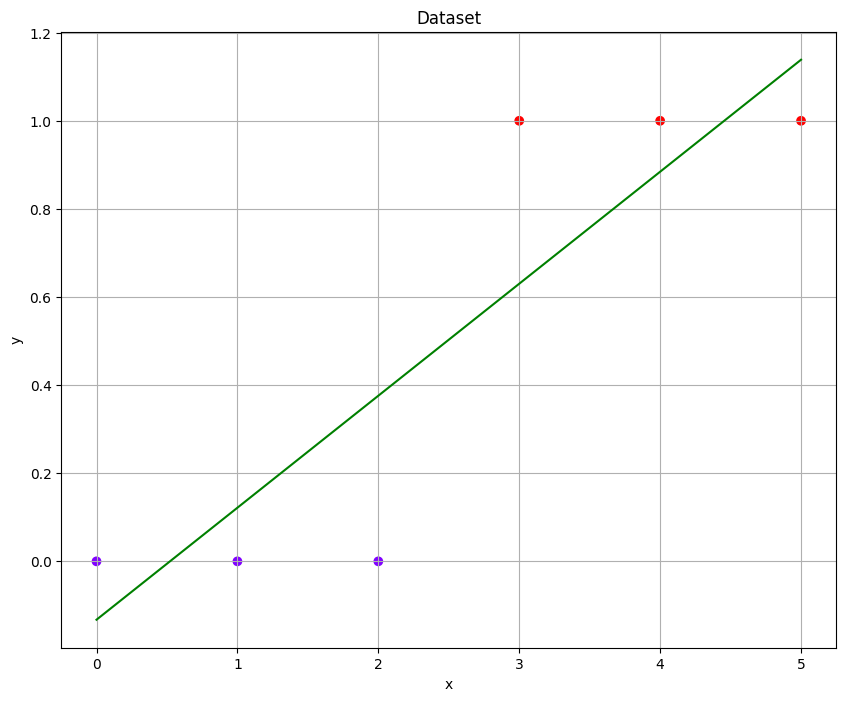

In [27]:
plot_data(hours, passed, w1, b1)

Let's also make a prediction for x = 20 using the regression line

In [28]:
x= 20
y = w1 * x + b1
print(y.item())

4.952032812090858


We can observe that linear regression doesn’t restrict its predictions to just 0 or 1. It can output any real number, including values below 0 or above 1. However, in our case, we’re dealing with a classification problem where we want to predict discrete categories. One simple approach is to apply a threshold. For example, 0.5. If the predicted value is below 0.5, we classify the student as having failed (y = 0). If it's 0.5 or higher, we classify them as having passed (y = 1). Let’s visualize this by drawing a vertical line on the plot at the point where the regression line crosses this threshold.

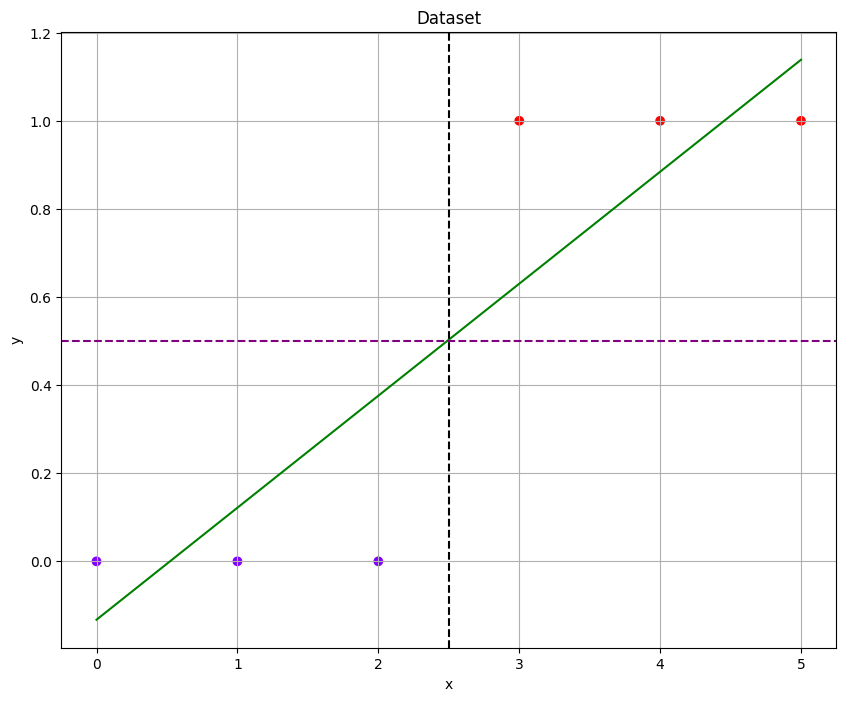

In [29]:
plot_data(hours, passed, w1, b1, thresh=(2.5, 0.5))

At first glance, this looks like a pretty good model. It classifies students who studied less than 2.5 hours as having failed, and those who studied 3 hours or more as having passed. Essentially, the model is saying: the more you study, the more likely you are to pass. That seems reasonable!

But real-world data is rarely this clean. In practice, we want models that make accurate predictions even when the data is messy or contains outliers.

Let’s test how robust our model really is by adding a new data point: (30, 1). This represents a student who studied for 30 hours and passed. While this data point shouldn’t affect how we classify the other students, let’s see what impact it has on the model’s decision boundary.

In [30]:
new_hours = np.array([0, 1, 2, 3, 4, 5, 30])
new_passed = np.array([0, 0, 0, 1, 1, 1, 1])
w = np.zeros((1))
b = 0
num_iters = 1000
alpha = 0.01
print(f"Start: w = {w.item()}, b = {b:.3f}")
w2, b2 = gradient_descent(new_hours.reshape(-1,1), new_passed.reshape(-1,1), w.reshape(-1,1), b, alpha, num_iters)

Start: w = 0.0, b = 0.000
Iteration    0: w: 0.06, b: 0.005714285714285714
Iteration  100: w: 0.034107554041448024, b: 0.21053866561304294
Iteration  200: w: 0.029262380675862187, b: 0.31283979434780196
Iteration  300: w: 0.026851427593004625, b: 0.36374472655409323
Iteration  400: w: 0.025651739918456883, b: 0.3890749663566833
Iteration  500: w: 0.025054776615149495, b: 0.4016792665815921
Iteration  600: w: 0.024757728314115636, b: 0.407951152888148
Iteration  700: w: 0.0246099173973336, b: 0.4110720368039898
Iteration  800: w: 0.02453636684328597, b: 0.41262498530147435
Iteration  900: w: 0.024499768166283714, b: 0.41339773081232084


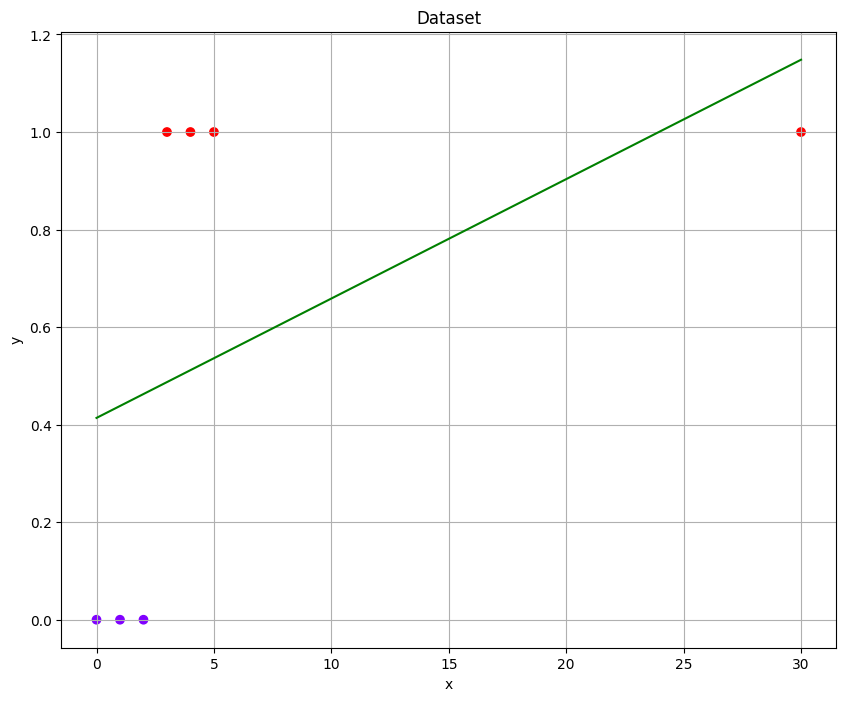

In [31]:
plot_data(new_hours, new_passed, w2, b2)

We can see that adding the new data point has shifted the regression line. If we continue using the same threshold of 0.5 to make predictions, we now notice that some of the original points are being misclassified. That’s a problem adding just one new data point shouldn’t drastically change how we classify the rest of the data.

What we’re observing here is a key limitation of linear regression when used for classification: adding an outlier causes the regression line and with it, the decision boundary to shift. This shift can lead to incorrect predictions. You'll learn more about decision boundaries in a later section, but for now, just know that they define where the model draws the line between different classes.


❓Question: Why does linear regression fail to properly classify the data?

<details>
<summary>✅ Answer</summary>

In linear regression, the model tries to minimize the squared error between predictions and the true values.

In the first plot, the x-values are close together, and the model can draw a line that lands nicely between class 0 and class 1. A threshold at 0.5 gives a good split.

But in the second plot, when we add the point (30, 1), the model tries to accommodate the new point because it's trying to minimize squared error across all points, and not just preserve the decision boundary. The loss function doesn’t care if a predicted 0.4 or 0.49 results in a wrong class, it only cares about how close it is to the actual label numerically.

This is misaligned with classification goals (i.e. getting the label right).
</details>

#### The Sigmoid Function

So far we've seen that the objective function of linear regression doesn't align with the goals of classification tasks.

In classification tasks, ideally we want our model to be able to output the probability that an input belongs to a class but linear regression doesn’t "cap" predictions between 0 and 1. It can happily predict values like 1.5 or -0.2, which makes no sense in a classification task. What we've done to address this issue is to manually impose a decision boundary (threshold like 0.5 or 0.6). But this decision boundary is fragile. A single point far from others can shift the boundary inappropriately just as we've seen in the example above.


We want a model that outputs probabilities (values between 0 and 1) for each input. But just predicting probabilities isn't enough. We also need an objective function that rewards correct classifications, not just predictions close in value to the labels. For now, let’s focus on building a model that can output valid probabilities.


How can we get this model? For now let's focus on getting the model to output probabilities.


🤔 **Pause and reflect:** How can we turn the scores from the linear regression model into probabilities?




Sigmoid function:

$$
\
\sigma(z) = \frac{1}{1 + e^{-z}}
\
$$


The sigmoid function maps any real-valued input 𝑧 to the range (0,1). We apply the sigmoid function to the model’s output to squash it into a range between 0 and 1, allowing us to interpret the result as a probability.


⏸️📖 **Pause and read:** Read the first three sections of this article about the sigmoid function https://en.wikipedia.org/wiki/Sigmoid_function

For now we'll modify our linear regression model to use the sigmoid function to convert it's output scores into probabilities and use this in our gradient descent to see how the behavior of the model changes. We'll use an already implemented loss function and then discuss it in detail in the next section.

**💻 Code task: Implement the sigmoid function**

Using the sigmoid function defined above. Your code should take in the array `x` as input and output the array after applying the sigmoid function.

In [32]:
def sigmoid(x: np.array):
  # your code here
  x_out = 1 / (1 + np.exp(-x))

  return x_out

🧪 Test your code

In [33]:
def test_sigmoid(n, x):
  y_pred = sigmoid(x)
  y = jax.nn.sigmoid(x)
  assert np.allclose(y_pred, y)
  assert y_pred.shape == y.shape
  for i in range(len(x)):
    if x[i] > 0:
      assert sigmoid(x[i]) > 0.5
    elif x[i] < 0:
      assert sigmoid(x[i]) < 0.5
    else:
      assert sigmoid(x[i]) == 0.5
  print(f"Test {n}: passed!")

test_sigmoid(1, np.array([0.0, 0.0, 0.0]))
test_sigmoid(2, np.array([1.0]))
test_sigmoid(3, np.array([-1.0]))

Test 1: passed!
Test 2: passed!
Test 3: passed!


In [36]:
# @title 🔓Solution - sigmoid function (Try not to peek until you've given it a good try!')
def sigmoid(x: jnp.array):
  x_out = 1 / (1 + np.exp(-x))
  return x_out

💻 **Code task: Implement gradient descent with logistic regression [Optional]**

Now modify your `gradient_descent` function to support logistic regression. When the argument logistic=True, apply the sigmoid function to the model’s predictions (y_hat). Otherwise, keep using the linear output.

In [61]:
def gradient_descent(x, y, w_in, b_in, alpha, num_iters, logistic=False):
  """
    Performs gradient descent to optimize the parameters of a linear regression model.

    Parameters:
    ----------
    x : np.ndarray
        Input features of shape (n_samples, 1).
    y : np.ndarray
        Target labels of shape (n_samples, 1).
    w_in : np.ndarray
        Initial weight parameter of the model of shape (1, 1).
    b_in : float
        Initial bias parameter of the model.
    alpha : float
        Learning rate that controls the step size in each iteration.
    num_iters : int
        Number of iterations to run the gradient descent loop.

    Returns:
    -------
    w : np.ndarray
        Optimized weight parameter of shape (1).
    b : float
        Optimized bias parameter.
  """
  # initialize parameters
  w = w_in
  b = b_in

  for i in range(num_iters):
    # make prediction
    y_hat = x @ w + b
    if logistic:
      y_hat = sigmoid(y_hat)

    # calculate gradient
    # g_w, g_b = compute_gradient(x, y, y_hat, w, b)
    dj_db,dj_dw = compute_gradient(x, y, y_hat, w, b)

    # update parameters
    w = w - alpha * dj_dw
    b = b - alpha * dj_db

    if i% math.ceil(num_iters / 10) == 0:
      print(f"Iteration {i:4d}: w: {w.item()}, b: {b}")
  return w, b

🧪 Test your code

In [40]:
def test_gradient_descent(logistic):
  hours = np.array([0, 1, 2, 3, 4, 5])
  passed = np.array([0, 0, 0, 1, 1, 1])
  w = np.zeros((1))
  b = 0.0
  w, b = gradient_descent(hours.reshape(-1, 1), passed.reshape(-1, 1), w.reshape(-1, 1), b, 0.01, 100, logistic=logistic)
  assert w != 0.0
  assert b != 0.0
  print("Test passed!")

test_gradient_descent(True)

Test passed!


<details>
<summary>💡Hint</summary>

You can use a simple `if logistic:` condition to decide whether to apply the sigmoid function.
</details>

In [53]:
# @title 🔓Solution - Gradient descent for logistic regression (Try not to peek until you've given it a good try!')
def gradient_descent(x, y, w_in, b_in, alpha, num_iters, logistic=False):
    w = w_in
    b = b_in

    for i in range(num_iters):

        y_hat  =  sigmoid(x @ w + b) if logistic else x @ w + b

        # Calculate the gradient
        dj_db,dj_dw = compute_gradient(x, y, y_hat, w, b)

        # Update Parameters using w, b, alpha and gradient
        w = w - (alpha * dj_dw)
        b = b - (alpha * dj_db)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: w: {w.item()}, b: {b}")

    return w.reshape(1), b

In [62]:
w = np.zeros((1))
b = 0.0
alpha = 0.01
num_iters = 30000
print(f"Start: w = {w.item()}, b = {b:.3f}")
log_w, log_b = gradient_descent(new_hours.reshape(-1,1), new_passed.reshape(-1,1), w.reshape(-1,1), b, alpha, num_iters = 30000, logistic=True)

Start: w = 0.0, b = 0.000
Iteration    0: w: 0.027857142857142858, b: 0.0007142857142857143
Iteration 3000: w: 1.2357492260919938, b: -2.622387391760009
Iteration 6000: w: 1.669713598496622, b: -3.80494889166415
Iteration 9000: w: 1.972246907845964, b: -4.6076660753382495
Iteration 12000: w: 2.2119960807238654, b: -5.234923574895938
Iteration 15000: w: 2.4141235145487543, b: -5.759088668365956
Iteration 18000: w: 2.5907719583092415, b: -6.214385781207171
Iteration 21000: w: 2.7487875642494446, b: -6.619837856857195
Iteration 24000: w: 2.8924415373337333, b: -6.9871831275101455
Iteration 27000: w: 3.0245963501966804, b: -7.324218225111774


Let's visualize our new model on the new dataset

using logistic regression


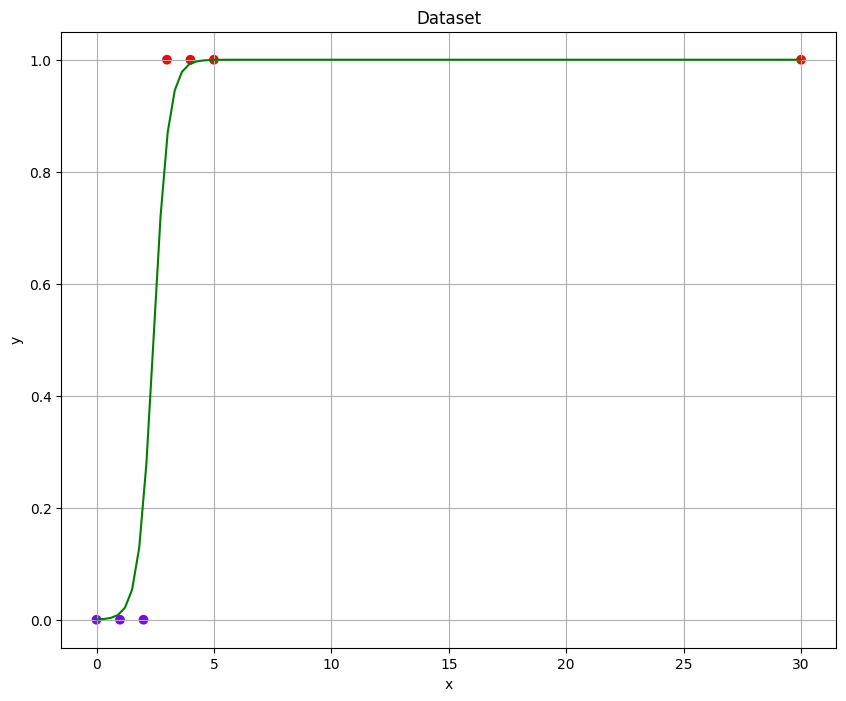

In [63]:
plot_data(new_hours, new_passed, log_w, log_b, logistic=True)

#### Loss landscape visualisation

In this subsection, we’ll explore the objective function used to optimize a logistic regression model

Remember that in linear regression our loss function was the mean squared error loss and this is what the loss landscape looked like

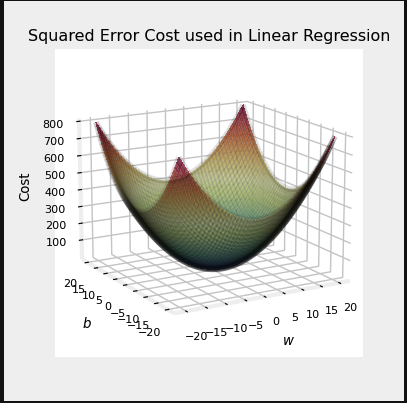

Run the cell below to use the mean squared error function to optimise the logistic regression model and see what the loss landscape looks like.

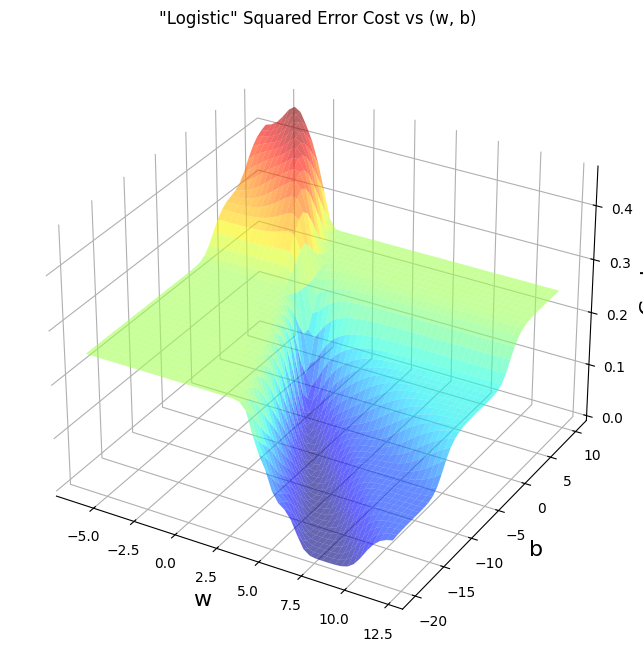

In [64]:
x_train = np.array([0, 1, 2, 3, 4, 5],dtype=np.float32)
y_train = np.array([0,  0, 0, 1, 1, 1],dtype=np.float32)
plt_logistic_squared_error(x_train, y_train, compute_cost_logistic_sq_err)
plt.show()

Ideally, we want a nice, smooth, convex bowl where gradient descent can easily roll down to the global minimum.

🧨 Problems with the Landscape
1. Non-convexity: The surface isn’t a clean bowl like in linear regression. There are ripples, plateaus, and flat regions — which can confuse optimization algorithms.

2. Multiple low-gradient regions: The gradients (slopes) are nearly flat in large regions. Gradient descent might get stuck or slow down dramatically in these flat areas.

<details>
<summary>🔬 Note: Why does MSE loss cause this?</summary>

In linear regression, MSE makes sense: you're penalizing how far your prediction is from the true value. But in classification, you're predicting a probability (like 0.9) and the label is discrete (0 or 1).
If your model predicts 0.95 for a class 1 label, that’s very good, but MSE still penalizes it for not being exactly 1.
In other words, MSE doesn’t care about probability confidence, it just cares about numbers being numerically close.
That causes small gradients near 0 and 1 (where sigmoid flattens), making training slow and poor handling of uncertainty.

We really want to maximize the ability of the model to make true predictions.
</details>






#### Cross-Entropy Loss function derivation

1️⃣ **We need a loss function that:**

1. Understands that we're predicting probabilities

2. Penalizes confident wrong predictions harshly and rewards confident correct predictions

3. Produces a clean, convex surface for optimization


**What Makes a Good Model?**

🎲 **Think of it as a guessing game**

Since our model assigns probabilities to outcomes, better models would give higher probabilities to the actual outcome of events for every datapoint in the dataset. We can then calculate the total probabilities assigned by a model and use this value to evaluate how good a model is. Our new goal during gradient descent then becomes to maximize this probability. This method is called the **maximum likelihood**.

```
Bad Model:  [▂    ] 0.2 → ✓ (correct outcome)
Good Model: [████▉ ] 0.9 → ✓ (correct outcome)
```
> 💡 **Key Insight**: We want to maximize the probability our model assigns to the correct answers.




2️⃣ **The Math Behind It**

If we assume that the datapoints in our dataset are independent events then the probability for the whole arrangement (i.e the total probability by the model) is the product of the probabilities of all the datapoints.

```
Total Probability = P₁ × P₂ × P₃ × ... × Pₙ
```

❓Question: Which of the following statement is true if the model has a high total probability

1. The model classifies all red points correctly
2. The model classifies all purple points correctly
3. The model classifies most points correctly
4. The model classifies all points correctly

<details>
<summary>✅ Answer </summary>
3. The model classifies most points correctly.
</details>

3️⃣ **The Logarithm Trick**

🤔 **Problem**
What happens when you multiply many small numbers (0.1 × 0.3 × 0.2 × ...)?

<details>
<summary>✅ Answer</summary>

You get tiny numbers that cause **numerical instability**! Your computer can't handle numbers like 0.0000000001 reliably.

</details>

🔄 **From Multiplication to Addition**

```
log(A × B × C) = log(A) + log(B) + log(C)
```

**New Formula:**
```
log(Total Probability) = log(P₁) + log(P₂) + ... + log(Pₙ)
```

> 💡 **Key Insight**: Maximizing probability = Maximizing log probability


4️⃣ **From Maximizing to Minimizing**

📊 **The Sign Flip**

Let's see what happens to log(p) for different probability values:

| Probability (p) | log(p) | -log(p) |
|----------------|--------|---------|
| 0.9 (confident, correct) | -0.11 | **0.11** (small penalty) |
| 0.5 (uncertain) | -0.69 | **0.69** (medium penalty) |
| 0.1 (confident, wrong) | -2.30 | **2.30** (large penalty) |

The log of probabilities are negative numbers. This is because the logarithm of a number between 0 and 1 is always a negative number since the logarithm of one is zero. So we'll take the negative of the logarithm of the probabilities and we'll get positive numbers.

**New objective:**
```
Minimize: -log(P₁) - log(P₂) - ... - log(Pₙ)
```

5️⃣ Binary Classification: The Final Formula

For binary classification (0 or 1), the probability formula is:

```
p(y|x) = ŷʸ(1-ŷ)¹⁻ʸ
```

❓Question: What is p(y|x) when y=1 and when y=0?

<details>
<summary>✅ Answer</summary>

**When y=1:** p(y|x) = ŷ¹(1-ŷ)⁰ = ŷ  
**When y=0:** p(y|x) = ŷ⁰(1-ŷ)¹ = (1-ŷ)

It gives us exactly what we want.
</details>

Taking the negative log:

```
L = -log(p(y|x)) = -(y log(ŷ) + (1-y)log(1-ŷ))
```

> **This is Cross-Entropy Loss!** It penalizes confident wrong predictions harshly and rewards confident correct predictions.


<details>
<summary>🔬 Note</summary>
This method is actually much more powerful than we think. When a pont is misclassified the negative log of it's probability is high whereas the points that are correctly classified have small values and the reason for this is again is that a correctly classified point will have a probability that as close to 1, which when we take the negative of the logarithm, we'll get a small value. Thus we can think of the negatives of these logarithms as errors at each point. Points that are correctly classified will have small errors and points that are misclassified will have large errors.And now we've concluded that our cross entropy will tell us if a model is good or bad.So now our goal has changed from maximizing a probability to minimizing a cross entropy in order to get from a bad model to a good model. The cross entropy is actually the error function that we're looking for.
</details>

**💻 Code task: Implement Cross Entropy Loss**

Implement the function `cross_entropy_loss` that computes the cost (or loss) of a logistic regression model using the equation:

  `L = -(y * log(ŷ) + (1-y) * log(1-ŷ))`

Where:
- y is the true label (0 or 1) `y_true`
- ŷ is the predicted probability (between 0 and 1) `y_pred`
- L is the loss (higher = worse prediction) `loss`

In [ ]:
def cross_entropy_loss(y_true, y_pred):
    """
    Computes binary cross-entropy loss between true labels and predicted probabilities.

    Parameters:
    -----------
    y_true : array-like of shape (n_samples,)
        True binary labels (0 or 1)
    y_pred : array-like of shape (n_samples,)
        Predicted probabilities (between 0 and 1)

    Returns:
    --------
    float
        Average cross-entropy loss across all samples
    """
    # Convert inputs to numpy arrays for easier computation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # TODO: Implement the cross-entropy formula
    # Formula: -(y * log(ŷ) + (1-y) * log(1-ŷ))
    loss = # YOUR CODE HERE

    # TODO: Return the average loss across all samples
    return # YOUR CODE HERE


<details>
<summary>💡 Hint</summary>

1. Use `np.log()` for natural logarithm
2. Remember to take the average across all samples
3. The formula handles both y=0 and y=1 cases automatically
</details>

In [ ]:
# @title 🔓Solution - cross entropy loss (Try not to peek until you've given it a good try!')
def cross_entropy_loss(y_true, y_pred):
  m = y_true.shape[0]
  return (1/m)*(np.dot(-y_true.T, np.log(y_pred)) - np.dot((1-y_true).T, np.log(1-y_pred)))

**💻 Code task: Implement Logistic Regression Cost Function**

Implement a function `compute_cost` that computes the cost (or loss) of a logistic regression model using the `cross_entropy_loss` function.

In [ ]:
def compute_cost(x, y, w, b, lambda_=0, safe=True):
    """
    Computes the total cost for logistic regression.

    This is the objective function that we want to MINIMIZE during training.
    Lower cost = better model performance on the training data.

    Parameters
    ----------
    x : np.ndarray of shape (m, n)
        Input feature matrix where:
        - m = number of training examples
        - n = number of features

    y : np.ndarray of shape (m,) or (m, 1)
        True binary labels (0 or 1)

    w : np.ndarray of shape (n, 1)
        Model weights (one per feature)

    b : float
        Model bias term (intercept)

    lambda_ (to be ignored) : float, default=0


    safe (to be ignored) : bool, default=True

    Returns
    -------
    total_cost : float
        The computed cost (loss)
        - Lower is better (perfect predictions → cost ≈ 0)
        - Higher means worse predictions or overfitting
    """

    # Convert inputs to numpy arrays and ensure proper shapes
    X = np.array(X)
    y = np.array(y).flatten()  # Ensure y is 1D
    w = np.array(w).flatten()  # Ensure w is 1D

    # Get dimensions
    m, n = X.shape  # m = samples, n = features

    # STEP 1: Compute linear combination z = X @ w + b
    # TODO: Implement the linear combination
    # Hint: Use matrix multiplication (X @ w) and add bias b
    z = # YOUR CODE HERE

    if safe:
        # Clip z to prevent numerical overflow in sigmoid
        z = np.clip(z, -500, 500)

    # STEP 2: Apply sigmoid activation to get predicted probabilities
    # TODO: Use the sigmoid function to convert z to probabilities
    # Hint: y_pred = sigmoid(z)
    y_pred = # YOUR CODE HERE

    if safe:
        # Clip predictions away from 0 and 1 to prevent log(0)
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    # STEP 3: Compute cross-entropy loss
    # TODO: use the cross-entropy_loss function previously implemented
    # Hint: Use np.log() and remember to take the mean across all samples
    total_cost = # YOUR CODE HERE

    return total_cost


<details>
<summary>💡 Hints</summary>

- Make sure all inputs (y, w, predictions) are 2D column vectors to avoid broadcasting issues.
- Use np.dot() or matrix multiplication to compute the cost efficiently:
</details>

🧪 Test your code

In [ ]:
x_test = np.array([
    [1.0, 2.0],
    [2.0, 1.0],
    [3.0, 4.0],
    [4.0, 3.0]
])
y_test = np.array([0, 1, 1, 0])

# Reshape inputs
w_test = np.array([0.1, -0.2])
b_test = 0.05

# Run student function
cost = compute_cost_matrix(x_test, y_test, w_test, b_test, logistic=True, lambda_=0)

# Print result
print("Logistic Regression Cost:", cost)

# Expected behavior: cost should be a small positive float
assert isinstance(cost, float) or np.isscalar(cost), "Returned cost must be a scalar"
assert cost > 0, "Cost should be positive"
print("All tests passed!")

In [ ]:
# @title 🔓Solution - Logistic regression cost function (Try not to peek until you've given it a good try!')
def compute_cost_matrix(X, y, w, b, logistic=False, lambda_=0, safe=True):
    m = X.shape[0]
    y = y.reshape(-1,1)             # ensure 2D
    w = w.reshape(-1,1)             # ensure 2D
    if logistic:
        if safe:  #safe from overflow
            cost = -(y * z) + log_1pexp(z)
            cost = np.sum(cost)/m
        else:
            f    = sigmoid(X @ w + b)
            cost = (1/m)*(np.dot(-y.T, np.log(f)) - np.dot((1-y).T, np.log(1-f)))
            cost = cost[0,0]
    else:
        f    = X @ w + b
        cost = (1/(2*m)) * np.sum((f - y)**2)
    reg_cost = (lambda_/(2*m)) * np.sum(w**2)
    total_cost = cost + reg_cost
    return total_cost

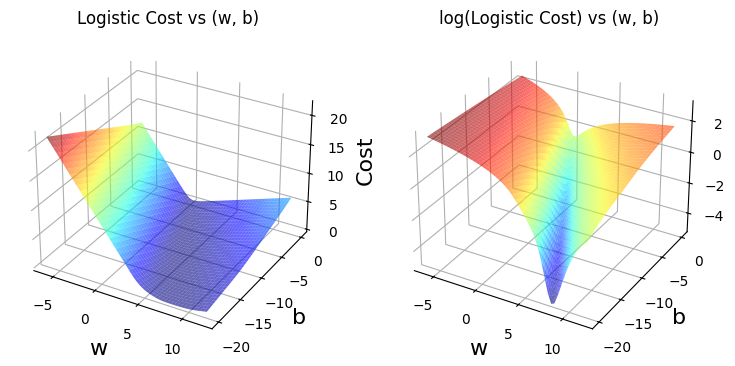

In [ ]:
# visualze the new losslandscape
cost = plt_logistic_cost(x_train,y_train, compute_cost_matrix)

This curve is well suited to gradient descent! It does not have plateaus, local minima, or discontinuities. Note, it is not a bowl as in the case of squared error. Both the cost and the log of the cost are plotted to illuminate the fact that the curve, when the cost is small, has a slope and continues to decline.

Using mean squared error in logistic regression is like using a thermometer to measure speed, it's the wrong tool for the job. We use cross-entropy not just for theoretical beauty, but because it gives us:

1. Faster training

2. Better decision boundaries

3. A smoother optimization surface

 🎓 Quick recap

Let's think about what we've actually done here

- Linear regression treats classification as a numerical prediction problem.
- It can output nonsensical values and is **sensitive to outliers**.
- Logistic regression fixes this by:
  - Outputting **probabilities**
  - Being **bounded between 0 and 1**
  - Having a natural **decision boundary** (usually 0.5)

👉 Logistic regression is *exactly* what we need when the task is to **classify**.


#### Non-linear Models: Working with more complex data


Let's look at a more complex dataset where we would need a more complex decision boundary to classify the data.

Let's generate a dataset with two spirals arranged in a swiss-roll type structure, and where each spiral forms a "class" that we want to be able to classify (i.e. the classes are very non-linearly distributed).



First we define some hyperparameters that will be used by the next few cells. Try changing these values to see how the models work with different data.

In [ ]:
num_classes = 3    # The number of classes (distinct groups) of data (these are our "y" values)
dimensions = 2    # The number of dimensions of our input or "X" values
points_per_class = 100    # number of X points to generate for each of the y values

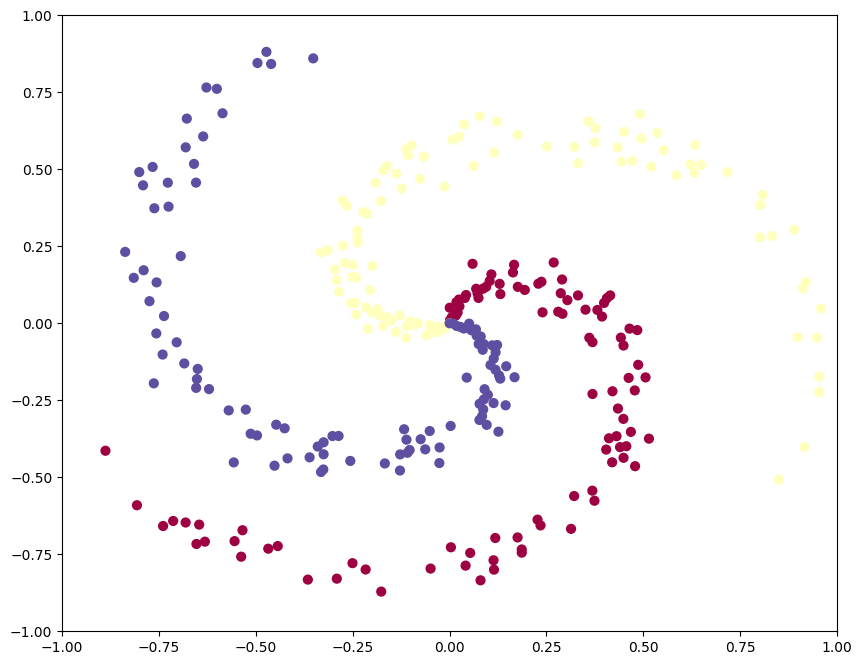

In [ ]:
# Spiral dataset
# Setting a random seed allows us to get the exact same data each time we run the cell.
np.random.seed(0)

x, y = generate_spiral_data(num_classes, dimensions, points_per_class)
fig = plot_spiral_data(x, y)

In the cells below, we have implemented a linear classifier using similar functions to the ones you've implemented in the previous section. Take sometime to read through the code and reassure yourself that you understand it.

In [ ]:
learning_rate = 1e-0
reg_lambda = 1e-3    # Regularization strength.
W_init = 0.01 * np.random.randn(dimensions, num_classes)

In [ ]:
class LinearModel(object):
    def __init__(self):
        # Initialize the model parameters.
        self.W = np.copy(W_init)
        self.b = np.zeros((1, num_classes))

    def predictions(self, X):
        """Make predictions of classes (y values) given some inputs (X)."""
        # Evaluate class scores/"logits": [points_per_class*num_classes x num_classes].
        logits = self.get_logits(X)

        # Compute the class probabilities.
        probs = softmax(logits)

        return probs

    def loss(self, probs, y):
        """Calculate the loss given model predictions and true targets."""
        num_examples = probs.shape[0]
        data_loss = cross_entropy(probs, y)
        regulariser = l2_loss([self.W])
        return data_loss + regulariser

    def update(self, probs, X, y):
        """Update the model parameters using back-propagation and gradient descent."""
        # Calculate the gradient of the loss with respect to logits
        dlogits = self.derivative_loss_logits(probs, y)

        # Gradient of the loss wrt W
        dW = self.derivative_loss_W(X, dlogits)

        # Gradient of the loss wrt b
        db = self.derivative_loss_b(dlogits)

        # Don't forget the gradient on the regularization term.
        dW += self.derivative_regularisation()

        # Perform a parameter update.
        self.W += -learning_rate * dW
        self.b += -learning_rate * db

    def get_logits(self, X):
        """Calculate the un-normalised model scores."""
        return np.dot(X, self.W) + self.b

    def derivative_loss_logits(self, probs, y):
        """Calculate the derivative of the loss with respect to logits."""
        num_examples = y.shape[0]
        dlogits = probs
        dlogits[range(num_examples), y] -= 1
        dlogits /= num_examples
        return dlogits

    def derivative_loss_W(self, X, dlogits):
        """Calculate the derivative of the loss wrt W."""
        return np.dot(X.T, dlogits)

    def derivative_loss_b(self, dlogits):
        """Calculate the derivative of the loss wrt b."""
        return np.sum(dlogits, axis=0, keepdims=True)

    def derivative_regularisation(self):
        return reg_lambda * self.W

We've also defined a function to evaluate the model

In [ ]:
def evaluate_model(model):
    # Get the probabilites/scores that the model assigns to each class for each x datapoint.
    scores = model.get_logits(x)    # The shape of scores is [num_data_points, num_classes]

    # The index of the maximum score along the 2nd dimension is the class that the model thinks is most likely (y^) for each datapoint.
    predicted_class = np.argmax(scores, axis=1)

    # What proportion of the class predictions made by the model (y^) agree with the true class values (y) ?
    print ('Accuracy: %.2f' % (np.mean(predicted_class == y)))

Run the cells below to train and evaluate the model

In [ ]:
def train_model(model, epochs, report_every, render_fn=None,render_args={}):
    frames = []
    for i in range(epochs):

        # Get the model predictions for our spiral dataset x.
        probs = model.predictions(x)

        # Compute the loss
        loss = model.loss(probs, y)

        # Print the loss value every `report_every` steps.
        if i % report_every == 0:
            print("iteration %d: loss %f" % (i, loss))
            if render_fn:
                frame = render_fn(**render_args)
                frames.append(frame)

        # Use back-propagation to update the model parameters:
        model.update(probs, x, y)

    if frames: return frames

In [ ]:
# Create an instance of our LinearModel.
linear_model = LinearModel()

# Now we train the linear model for 200 epochs.
train_model(linear_model, 200, 10)

iteration 0: loss 1.100624
iteration 10: loss 0.918448
iteration 20: loss 0.851978
iteration 30: loss 0.822560
iteration 40: loss 0.807703
iteration 50: loss 0.799514
iteration 60: loss 0.794720
iteration 70: loss 0.791788
iteration 80: loss 0.789936
iteration 90: loss 0.788736
iteration 100: loss 0.787944
iteration 110: loss 0.787413
iteration 120: loss 0.787052
iteration 130: loss 0.786805
iteration 140: loss 0.786634
iteration 150: loss 0.786515
iteration 160: loss 0.786432
iteration 170: loss 0.786373
iteration 180: loss 0.786332
iteration 190: loss 0.786302


In [ ]:
# Now evaluate the trained linear model
evaluate_model(linear_model)

Accuracy: 0.49


This is not a very good result (we are misclassifying around 50% of the data points, and these are data points that we've seen before!), lets visualise the decision boundary to determine what's going on.

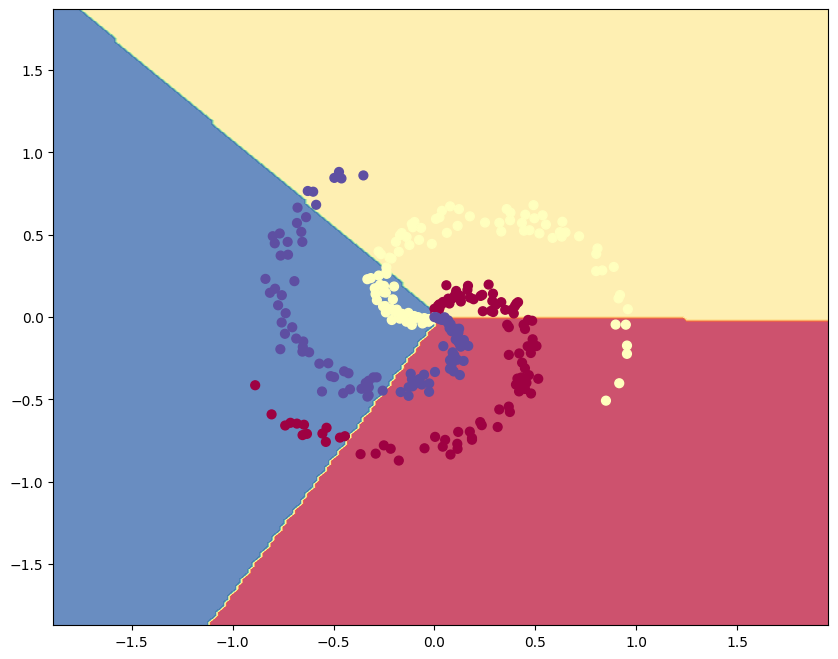

In [ ]:
plot_decision_boundary(x, linear_model)

The linear model resulted in decision boundaries that were straight lines in 2D space. Using these straight lines, it is impossible to accurately separate our spiral-shaped data. We need a more complex model that can represent more complex (nonlinear) decision boundaries. Intuitively, we want a "curved" decision boundary that can adapt to the curved shape of the data.

Neural networks solve this by adding non-linearity using **Activation Functions** between layers in the network.

Activation Functions introduces curves, bends, and twists in the decision boundary. There are many activation functions but a popular choice is the **ReLU Activation Function**

The output is 0 for negative inputs, and linear for positive inputs.

In code:

In [ ]:
def relu(value):
    """ ReLU is the "Rectified Linear Unit activation function", defined as:
                relu(x) = x if x > 0, and 0 if x <= 0
    """
    return np.maximum(0, value)

💻 Coding Task: Using a Non-Linear Model

So far, our LinearModel only learns linear decision boundaries.
To make it more powerful, we’ll extend it into a 1-hidden-layer neural network.

Your task is to implement two methods:

1. `hidden_layer(self, X)`: Takes input features `X` (shape: (batch_size, input_dim)). Computes the hidden representation and return the hidden activations `h`.

2. `get_logits(self, X)`: Use the hidden layer output `h` to compute logits. First call `self.hidden_layer(X)` to get `h`. Then compute logits `Z`.

In [ ]:
learning_rate = 1e-0
reg_lambda = 1e-3
num_hidden = 100    # Size of hidden layer.

non_linear_W_init = 0.01 * np.random.randn(dimensions, num_hidden)
non_linear_W2_init = 0.01 * np.random.randn(num_hidden, num_classes)

In [ ]:
class NonLinearModel(object):
    def __init__(self):
        # Initialize the model parameters.
        self.W = non_linear_W_init
        self.b = np.zeros((1, num_hidden))
        self.W2 = non_linear_W2_init
        self.b2 = np.zeros((1, num_classes))

    def hidden_layer(self, X):
        """Calculate the output of the hidden layer."""
        h = ...
        return h

    def get_logits(self, X):
        """Calculate the logits from the input data X."""
        h = ...
        Z = ...
        return Z

    def predictions(self, X):
        """Make predictions of classes (y values) given some inputs (X)."""
        # Evaluate class scores/"logits": [points_per_class*num_classes x num_classes].
        logits = self.get_logits(X)

        # Compute the class probabilities.
        probs = softmax(logits)

        return probs

    def loss(self, probs, y):
        """Calculate the loss given model predictions and true targets."""
        data_loss = cross_entropy(probs, y)
        regulariser = l2_loss([self.W, self.W2])
        return data_loss + regulariser

    def update(self, probs, X, y):
        """Update the model parameters using back-propagation and gradient descent."""
        hidden_output = self.hidden_layer(X)

        # Calculate the gradient of the loss with respect to logits
        dlogits = self.derivative_loss_logits(probs, y)

        # Backpropagate the gradient to the parameters.

        # We first backprop into parameters W2 and b2.
        dW2 = self.derivative_loss_W2(hidden_output, dlogits)
        db2 = self.derivative_loss_b2(dlogits)

        # Next, backprop into the hidden layer.
        dhidden = self.derivative_hidden(hidden_output, dlogits)

        # Finally, backprop into W,b.
        dW = self.derivative_loss_W(X, dhidden)
        db = self.derivative_loss_b(dhidden)

        # Add regularization gradient contribution.
        dW2 += self.derivative_regularisation_W2()
        dW += self.derivative_regularisation_W()

        # Perform a parameter update (one step of gradient descent).
        self.W += -learning_rate * dW
        self.b += -learning_rate * db
        self.W2 += -learning_rate * dW2
        self.b2 += -learning_rate * db2

    def derivative_loss_logits(self, logits, y):
        """Calculate the derivative of the loss with respect to logits."""
        num_examples = y.shape[0]
        dlogits = logits
        dlogits[range(num_examples),y] -= 1
        dlogits /= num_examples
        return dlogits

    def derivative_loss_W2(self, hidden_output, dlogits):
        """Calculate the derivative of the loss wrt W2."""
        dW2 = np.dot(hidden_output.T, dlogits)
        return dW2

    def derivative_loss_b2(self, dlogits):
        """Calculate the derivative of the loss wrt b2."""
        return np.sum(dlogits, axis=0, keepdims=True)

    def derivative_hidden(self, hidden_output, dlogits):
        """Calculate the derivative of the loss wrt the hidden layer."""
        # Calculate the gradient as if the hidden layer were a normal linear layer.
        dhidden = np.dot(dlogits, self.W2.T)

        # Now take the Relu non-linearity into account
        dhidden[hidden_output <= 0] = 0

        return dhidden

    def derivative_loss_W(self, X, dhidden):
        """Calculate the derivative of the loss wrt W."""
        return np.dot(X.T, dhidden)

    def derivative_loss_b(self, dhidden):
        """Calculate the derivative of the loss wrt b."""
        return np.sum(dhidden, axis=0, keepdims=True)

    def derivative_regularisation_W(self):
        """Calculate the gradient of the L2 loss wrt W."""
        return reg_lambda * self.W

    def derivative_regularisation_W2(self):
        """Calculate the gradient of the L2 loss wrt W2."""
        return reg_lambda * self.W2

In [ ]:
# @title 🔓Solution - Nonlinear model (Try not to peek until you've given it a good try!')
class NonLinearModel(object):
    def __init__(self):
        # Initialize the model parameters.
        self.W = non_linear_W_init
        self.b = np.zeros((1, num_hidden))
        self.W2 = non_linear_W2_init
        self.b2 = np.zeros((1, num_classes))

    def hidden_layer(self, X):
        """Calculate the output of the hidden layer."""
        h = relu(np.dot(X, self.W) + self.b)
        return h

    def get_logits(self, X):
        """Calculate the logits from the input data X."""
        h = self.hidden_layer(X)
        Z = np.dot(h, self.W2) + self.b2
        return Z

    def predictions(self, X):
        """Make predictions of classes (y values) given some inputs (X)."""
        # Evaluate class scores/"logits": [points_per_class*num_classes x num_classes].
        logits = self.get_logits(X)

        # Compute the class probabilities.
        probs = softmax(logits)

        return probs

    def loss(self, probs, y):
        """Calculate the loss given model predictions and true targets."""
        data_loss = cross_entropy(probs, y)
        regulariser = l2_loss([self.W, self.W2])
        return data_loss + regulariser

    def update(self, probs, X, y):
        """Update the model parameters using back-propagation and gradient descent."""
        hidden_output = self.hidden_layer(X)

        # Calculate the gradient of the loss with respect to logits
        dlogits = self.derivative_loss_logits(probs, y)

        # Backpropagate the gradient to the parameters.

        # We first backprop into parameters W2 and b2.
        dW2 = self.derivative_loss_W2(hidden_output, dlogits)
        db2 = self.derivative_loss_b2(dlogits)

        # Next, backprop into the hidden layer.
        dhidden = self.derivative_hidden(hidden_output, dlogits)

        # Finally, backprop into W,b.
        dW = self.derivative_loss_W(X, dhidden)
        db = self.derivative_loss_b(dhidden)

        # Add regularization gradient contribution.
        dW2 += self.derivative_regularisation_W2()
        dW += self.derivative_regularisation_W()

        # Perform a parameter update (one step of gradient descent).
        self.W += -learning_rate * dW
        self.b += -learning_rate * db
        self.W2 += -learning_rate * dW2
        self.b2 += -learning_rate * db2

    def derivative_loss_logits(self, logits, y):
        """Calculate the derivative of the loss with respect to logits."""
        num_examples = y.shape[0]
        dlogits = logits
        dlogits[range(num_examples),y] -= 1
        dlogits /= num_examples
        return dlogits

    def derivative_loss_W2(self, hidden_output, dlogits):
        """Calculate the derivative of the loss wrt W2."""
        dW2 = np.dot(hidden_output.T, dlogits)
        return dW2

    def derivative_loss_b2(self, dlogits):
        """Calculate the derivative of the loss wrt b2."""
        return np.sum(dlogits, axis=0, keepdims=True)

    def derivative_hidden(self, hidden_output, dlogits):
        """Calculate the derivative of the loss wrt the hidden layer."""
        # Calculate the gradient as if the hidden layer were a normal linear layer.
        dhidden = np.dot(dlogits, self.W2.T)

        # Now take the Relu non-linearity into account
        dhidden[hidden_output <= 0] = 0

        return dhidden

    def derivative_loss_W(self, X, dhidden):
        """Calculate the derivative of the loss wrt W."""
        return np.dot(X.T, dhidden)

    def derivative_loss_b(self, dhidden):
        """Calculate the derivative of the loss wrt b."""
        return np.sum(dhidden, axis=0, keepdims=True)

    def derivative_regularisation_W(self):
        """Calculate the gradient of the L2 loss wrt W."""
        return reg_lambda * self.W

    def derivative_regularisation_W2(self):
        """Calculate the gradient of the L2 loss wrt W2."""
        return reg_lambda * self.W2

In [ ]:
# Create an instance of our non-linear model.
non_linear_model = NonLinearModel()

# Train the model for 10000 epochs
train_model(non_linear_model, 10000, 1000)

iteration 0: loss 1.098763
iteration 1000: loss 0.294535
iteration 2000: loss 0.251367
iteration 3000: loss 0.246328
iteration 4000: loss 0.245189
iteration 5000: loss 0.244929
iteration 6000: loss 0.244840
iteration 7000: loss 0.244802
iteration 8000: loss 0.244749
iteration 9000: loss 0.244718


In [ ]:
# evaluate training set accuracy of the non-linear model
evaluate_model(non_linear_model)

Accuracy: 0.98


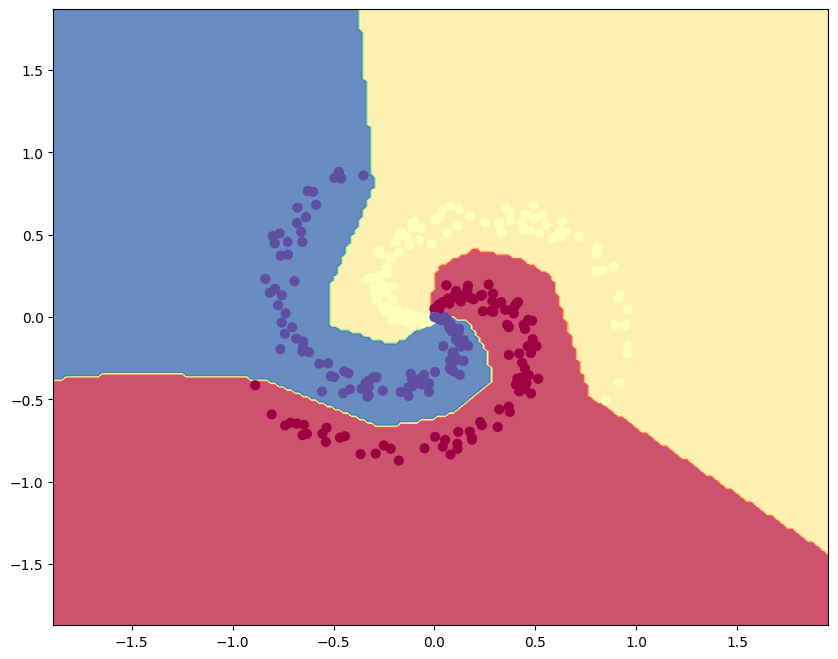

In [ ]:
plot_decision_boundary(x, non_linear_model)

## Build a simple binary classifier with JAX

Now that we have a solid understanding of logistic regression, let’s take things a step further by building a binary classifier using a Multi-Layer Perceptron (MLP) with JAX. We'll apply it to a real-world dataset related to tumor classification.

The code cell below loads the dataset for you. It reads the data from a CSV file, converts the target labels from "M" (malignant) and "B" (benign) to numerical values (1 and 0, respectively), and then splits the dataset into training and testing sets.

Feel free to open the dataset and explore it before we begin!

#### Load data

In [ ]:
from sklearn.datasets import load_breast_cancer

# Load breast cancer dataset from sklearn
data = load_breast_cancer()

# Convert the dataset to a pandas DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)

# Add the target variable to the DataFrame
df['target'] = data.target
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


convert our target column "diagnosis" to 1s and 0s cause we want to work with numbers.

In [ ]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    int64  
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [ ]:
# split dataset into test and train
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
# split each set into input and target
y_train = train_set.pop('target').astype(np.int32)
x_train = train_set


y_test = test_set.pop('target').astype(np.int32)
x_test = test_set

In [ ]:
x_train.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
68,9.029,17.33,58.79,250.5,0.10660,0.14130,0.31300,0.04375,0.2111,0.08046,...,10.31,22.65,65.50,324.7,0.14820,0.43650,1.25200,0.17500,0.4228,0.11750
181,21.090,26.57,142.70,1311.0,0.11410,0.28320,0.24870,0.14960,0.2395,0.07398,...,26.68,33.48,176.50,2089.0,0.14910,0.75840,0.67800,0.29030,0.4098,0.12840
63,9.173,13.86,59.20,260.9,0.07721,0.08751,0.05988,0.02180,0.2341,0.06963,...,10.01,19.23,65.59,310.1,0.09836,0.16780,0.13970,0.05087,0.3282,0.08490
248,10.650,25.22,68.01,347.0,0.09657,0.07234,0.02379,0.01615,0.1897,0.06329,...,12.25,35.19,77.98,455.7,0.14990,0.13980,0.11250,0.06136,0.3409,0.08147
60,10.170,14.88,64.55,311.9,0.11340,0.08061,0.01084,0.01290,0.2743,0.06960,...,11.02,17.45,69.86,368.6,0.12750,0.09866,0.02168,0.02579,0.3557,0.08020


In [ ]:
x_train.shape

(455, 30)

### Define a Multi-Layer Perceptron in JAX

If you took a look at the dataset, you would see that it contains a lot of features. The beautiful thing about deep neural networks is that we don't have to do feature extraction. The network itself learns the relevant features, usually in the first few layers.

When working with machine learning models, it’s important to organize your data into a format that can be easily shuffled, batched, and fed into the model during training. This is exactly what the `tf.data.Dataset` API is designed for. It allows you to:

- Efficiently load and preprocess data

- Shuffle and batch data for training and

- Iterate over data in a scalable way

One of the most common ways to create a dataset is using:

`tf.data.Dataset.from_tensor_slices((inputs, labels))`

It splits the given tensors into slices along the first dimension (like rows of a matrix). Each slice becomes one element in the dataset.

You can then apply `.shuffle()`, `.batch()`, `.map()`, etc. to prepare your data.




To learn more about tf.data.Dataset, refer to this [documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

At the heart of our model is a **Multilayer Perceptron (MLP)** a neural network with fully connected layers.

Just as in the previous tutorial, we'll use the `linen` api in JAX to build the MLP in this section.


It is a common convention to import the `linen` api as nn:

`import flax.linen as nn`

and call its corresponding classes using nn e.g `nn.Module`

To build our MLP

We'll use:
- `nn.Dense(features)` module for fully connected layers which applies the weight matrix on the input.
- `nn.gelu` as the activation function in each layer
- `nn.sigmoid` for the output layer

When we want to define a model's architecture, a natural question arises:

**How many layers should I use, and how big should each layer be?**

There’s actually no one-size-fits-all answer to this question which is why depth and width are hyperparameters that need to be tuned for each task.

As a rule of thumb: Start shallow and narrow, and increase only if the model underfits.

In the code task below, you’ll define your own MLP architecture. Once you get it working, experiment with different configurations:

- Increase the number of layers.

- Try doubling the layer size.

- Observe how the model performance changes.

You might be surprised how small tweaks can make a big difference!


💻 Code Task: Define a Multi-Layer Perceptron (MLP) Binary Classifier

Your goal is to complete the definition of an MLP model using Flax’s Linen API. This model will take input features from a tumor dataset and output a single logit representing whether the tumor is malignant or benign (binary classification).

You'll implement the model by completing the __call__ method of the MLP class.

1. Architecture

- Your model should consist of 4 fully connected (Dense) layers:

    - 3 hidden layers

    - 1 output layer

- These layers should use the layer sizes defined in the class constructor (already provided).

2. Activation Functions
- Use the GELU activation after each of the first 3 layers.
- Do not apply sigmoid at the final layer. This is because the sigmoid function will be applied later during loss computation.

This exercise is very similar to the model you built in part 1 of the ML foundation tutorial series so feel free to revisit it if you get stuck.

In [ ]:
import flax.linen as nn

class MLP(nn.Module):

  hidden_size_1: int
  hidden_size_2: int
  hidden_size_3: int
  output_size: int

  @nn.compact
  def __call__(self, x):

    # First layer with GeLU activation


    # Second layer with GeLU activation


    # Third layer with GeLU activation


    # Output layer


    return x


In [ ]:
# @title 🔓Solution - MLP in Jax(Try not to peek until you've given it a good try!')
class MLP(nn.Module):
  hidden_size_1: int
  hidden_size_2: int
  hidden_size_3: int
  output_size: int

  @nn.compact
  def __call__(self, x):
    # First layer with GeLU activation
    x = nn.Dense(self.hidden_size_1)(x)
    x = nn.gelu(x)

    # Second layer with GeLU activation
    x = nn.Dense(self.hidden_size_2)(x)
    x = nn.gelu(x)

    # Third layer with GeLU activation
    x = nn.Dense(self.hidden_size_3)(x)
    x = nn.gelu(x)

    # Third (output) layer
    x = nn.Dense(self.output_size)(x)

    return x

Once you’ve completed the MLP class implementation above, go ahead and define the following model configuration variables. Use 60, 60, and 30 as the sizes for the first three hidden layers. Then, initialize the model using these values.

- Set the `input_size` based on the shape of your dataset.

- Set the `output_size` according to the number of classes in your classification task.

In [ ]:
# Fill in the values for the variables below
seed = 32
input_size = #the vector size of one input in the dataset
hidden_size_1 =
hidden_size_2 =
hidden_size_3 =
output_size =

# Initialize the model
model =

key = jax.random.PRNGKey(seed)

dummy_data = jnp.zeros((1, input_size), dtype=float)


params = model.init(key, dummy_data)

# Print model parameters
print_param_shapes(params['params'])

<details>
<summary>💡 Hints</summary>

- Look at the shape of your input data, how many features does each sample have? That will determine the number of input features for your first linear layer.
- Since this is a binary classification task and your model should output a single probability, what should be the number of output units in your final layer?
</details>

In [ ]:
# @title 🔓Solution - Model initialisation Jax (Try not to peek until you've given it a good try!')
seed = 32
input_size = 30
hidden_size_1 = 60
hidden_size_2 = 60
hidden_size_3 = 30
output_size = 1

model = MLP(hidden_size_1, hidden_size_2, hidden_size_3, output_size)

key = jax.random.PRNGKey(seed)

dummy_data = jnp.zeros((1, input_size), dtype=float)


params = model.init(key, dummy_data)

# Print model parameters
print_param_shapes(params['params'])

Note that the shape of `dummy_data` must match the shape of the real input data.This is because `model.init` needs the input shape along with the model's configuration (e.g., hidden and output sizes) to initialize the correct parameter shapes.

🧪 Test your code

In [ ]:
z = model.apply(params, dummy_data)
assert z.shape == (1,1)
print(f"Model ouput shape: {z.shape}, Input shape: {dummy_data.shape}")

Model ouput shape: (1, 1), Input shape: (1, 30)


### 📊 Evaluation Metrics

In binary classification tasks, such as predicting whether a tumor is **malignant (1)** or **benign (0)**, evaluating our model goes beyond just checking whether predictions are right or wrong. Let’s explore several key metrics that give us deeper insight into the model's performance:


#### ✅ Accuracy

Accuracy measures the proportion of correct predictions out of total predictions:

$$
\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}}
$$

While useful, accuracy can be **misleading**, especially on **imbalanced datasets**. Imagine if only 5% of tumors are malignant. A model that always predicts "benign" will still have 95% accuracy, but be completely useless.

#### 🎯 Precision

Precision tells us **how many predicted positives were actually correct**:

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

Useful when **false positives are costly**, e.g., incorrectly diagnosing a healthy patient as having cancer.



💻 Code Task: Implement the precision evaluation metric.

You are given a partially implemented `Precision` metric class. Your task is to complete the `compute` method which should return the precision value using the fields `true_positives` and `pred_positives`.

The rest of the class is already provided for you:

In [ ]:
@struct.dataclass
class Precision(metrics.Metric):
  """
  Computes the precision from model outputs `logits` and `labels`.

  Attributes:
    - true_positives: Number of correctly predicted positive samples.
    - pred_positives: Total number of samples predicted as positive.
  """

  true_positives: jnp.array
  pred_positives: jnp.array

  @classmethod
  def empty(cls):
    return cls(true_positives=jnp.array(0, jnp.float32), pred_positives=jnp.array(0, jnp.int32))

  @classmethod
  def from_model_output(cls, *, logits: jnp.array, labels: jnp.array,
                        **_) -> metrics.Metric:
    """
    Creates a Precision instance from model outputs and ground truth labels.

    - `logits`: Raw model outputs of shape (batch_size, 2) for binary classification.
    - `labels`: Ground truth labels of shape (batch_size,).
    """
    assert logits.shape[-1] == 1, "Expected binary logits."
    preds = (jnp.array(logits) > 0.5).astype(int)
    return cls(
        true_positives=((preds == 1) & (labels == 1)).sum(),
        pred_positives=(preds == 1).sum(),
    )

  def merge(self, other: metrics.Metric) -> metrics.Metric:
    """
    Merges two Precision metric objects by summing their respective counts.
    """
    return type(self)(
        true_positives=self.true_positives + other.true_positives,
        pred_positives=self.pred_positives + other.pred_positives,
    )

  def compute(self):
    # TODO: Return the precision score using the fields self.true_positives, and self.pred_positives.
    ...



In [ ]:
# @title 🔓Solution - Metrics (Try not to peek until you've given it a good try!')
@struct.dataclass
class Precision(metrics.Metric):
  """
  Computes the precision from model outputs `logits` and `labels`.

  Attributes:
    - true_positives: Number of correctly predicted positive samples.
    - pred_positives: Total number of samples predicted as positive.
  """

  true_positives: jnp.array
  pred_positives: jnp.array

  @classmethod
  def empty(cls) -> Precision:
    return cls(true_positives=jnp.array(0, jnp.float32), pred_positives=jnp.array(0, jnp.int32))

  @classmethod
  def from_model_output(cls, *, logits: jnp.array, labels: jnp.array,
                        **_) -> metrics.Metric:
    """
    Creates a Precision instance from model outputs and ground truth labels.

    - `logits`: Raw model outputs of shape (batch_size, 2) for binary classification.
    - `labels`: Ground truth labels of shape (batch_size,).
    """
    assert logits.shape[-1] == 1, "Expected binary logits."
    preds = (jnp.array(logits) > 0.5).astype(int)
    return cls(
        true_positives=((preds == 1) & (labels == 1)).sum(),
        pred_positives=(preds == 1).sum(),
    )

  def merge(self, other: metrics.Metric) -> metrics.Metric:
    """
    Merges two Precision metric objects by summing their respective counts.
    """
    return type(self)(
        true_positives=self.true_positives + other.true_positives,
        pred_positives=self.pred_positives + other.pred_positives,
    )

  def compute(self):
    # TODO: Return the precision score using the fields self.true_positives, and self.pred_positives.
    return self.true_positives/self.pred_positives

#### 🚨 Recall (Sensitivity)

Recall tells us **how many actual positives were predicted**:

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

Important when **missing a true positive case is dangerous** e.g. failing to identify a malignant tumor.

💻 Code Task: Implement the recall evaluation metric

You are given a partially implemented `Recall` metric class. Your task is to complete the `compute` method which should return the recall value using the fields `true_positives` and `actual_positives`.

The rest of the class is already provided for you:

In [ ]:
@struct.dataclass
class Recall(metrics.Metric):
  """Computes the recall from model outputs `logits` and `labels`."""

  true_positives: jnp.array
  actual_postives: jnp.array

  @classmethod
  def empty(cls):
    return cls(true_positives=jnp.array(0, jnp.float32), actual_positives=jnp.array(0, jnp.int32))

  @classmethod
  def from_model_output(cls, *, logits: jnp.array, labels: jnp.array, **_) -> metrics.Metric:
    assert logits.shape[-1] == 1, "Expected binary logits."
    preds = (jnp.array(logits) > 0.5).astype(int)
    return cls(
        true_positives=((preds == 1) & (labels == 1)).sum(),
        actual_positives=(labels == 1).sum(),
    )

  def merge(self, other: metrics.Metric) -> metrics.Metric:
    return type(self)(
        true_positives=self.true_positives + other.true_positives,
        actual_positives=self.actual_positives + other.actual_positives,
    )

  def compute(self):
    # TODO: Implement recall = TP / Actual Positives
    # Note that Actual Positives is the same as TP + FN
    ...

In [ ]:
# @title 🔓Solution - Metrics (Try not to peek until you've given it a good try!')
@struct.dataclass
class Recall(metrics.Metric):
  """Computes the recall from model outputs `logits` and `labels`."""

  true_positives: jnp.array
  actual_postives: jnp.array

  @classmethod
  def empty(cls) -> Recall:
    return cls(true_positives=jnp.array(0, jnp.float32), pred_positives=jnp.array(0, jnp.int32))

  @classmethod
  def from_model_output(cls, *, logits: jnp.array, labels: jnp.array, **_) -> metrics.Metric:
    assert logits.shape[-1] == 1, "Expected binary logits."
    preds = (jnp.array(logits) > 0.5).astype(int)
    return cls(
        true_positives=((preds == 1) & (labels == 1)).sum(),
        actual_positives=(labels == 1).sum(),
    )

  def merge(self, other: metrics.Metric) -> metrics.Metric:
    return type(self)(
        true_positives=self.true_positives + other.true_positives,
        actual_positives=self.actual_positives + other.actual_positives,
    )

  def compute(self):
    return self.true_positives/self.actual_positives

While **precision** and **recall** provide deeper insight into classification performance, there are other useful metrics you should know about. For instance, the **confusion matrix** gives a complete picture by showing the number of **true positives**, **true negatives**, **false positives**, and **false negatives** in a single table. It’s especially useful for diagnosing what kinds of errors your model is making. Similarly, the **F1 score** combines precision and recall into a single metric, offering a balanced view that’s particularly helpful when working with imbalanced datasets. You’re encouraged to explore and experiment with these metrics to better evaluate and understand your models.

### Write a training loop

In JAX, we don’t have built-in high-level tools like `model.fit()` as in some other frameworks. Instead, we use **Optax**, a powerful and flexible library designed to handle:

- Loss functions like cross-entropy, mean squared error, etc.

- Optimizers like SGD, Adam, and AdamW for updating model parameters.

- Gradient transformations, learning rate schedules, and more.

In this tutorial, we would use `optax.sigmoid_binary_cross_entropy` as our loss function for binary classification.

We would also use Adam optimizer `optax.adamw` to apply gradient based updates to the model's weights during training. Optimizers would be discussed in detail in a future tutorial but for now you can think of Adam optimizer as an improvement upon the vanilla stochastic gradient descent.

We have defined the `optimizer` and the optimizer state `opt_state` in the cell below.

<details>
<summary>🔬 Note on the optimizer state</summary>

The optimizer state `opt_state` is a collection of internal variables maintained by the optimizer throughout training. These variables are specific to the optimization algorithm used.

For example, in the case of the Adam optimizer:
  - It maintains moving averages of the gradients (called first moments),
  - And moving averages of the squared gradients (second moments),
  - Along with a counter of the current step.

These moving averages help the optimizer adaptively adjust the learning rate for each parameter which can lead to faster and more stable convergence.

Unlike the model parameters, the optimizer state is not updated manually.
Instead, it's updated automatically each time we apply gradients using the optimizer. It's important to keep track of both the model parameters and the optimizer state during training.
</details>

In [ ]:
learning_rate = 0.001

optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

💻 Code Task: Loss Function and Gradient Computation in JAX

In this task, you’ll implement the loss function and the gradient computation needed to train your binary classification model using **JAX** and **Optax**.

1. Implement the loss function `loss_func(params, model, batch)`.
 This function computes the sigmoid binary cross-entropy loss between the model's predictions and the ground truth labels. You need to:
 - Extract the inputs and labels from the batch.
 - Use `model.apply()` to compute the logits from the input and model parameters.
 - Use `optax.sigmoid_binary_cross_entropy` module to compute the per-example loss. Remember that the loss should be the average loss of all the samples in the batch. View the documentation on how to use the binary cross entropy function [here](https://optax.readthedocs.io/en/latest/api/losses.html#optax.losses.sigmoid_binary_cross_entropy)
 - Return the loss and the logits (we’ll use both in training and evaluation).

2.  Implement a `loss_grad_fn`. This function wraps `loss_func` using `jax.value_and_grad` to compute gradients with respect to the model parameters. You need to:
- Use `jax.value_and_grad` to compute the gradients and
- Store this in the variable `loss_gradf_fn`

 Note that since our loss function returns a pair of output, we need to pass the parameter, `has_aux=True` to the `jax.value_and_grad` function. See documentation [here](https://docs.jax.dev/en/latest/_autosummary/jax.value_and_grad.html)

In [ ]:
def loss_func(params, model, batch):
  """Compute the sigmoid binary cross-entropy loss and return logits."""

  # Extract inputs and labels from batch

  # Calculate the logits

  labels = jnp.reshape(labels, logits.shape) # Reshape the labels to match the shape of the logits.

  # Compute binary cross-entropy loss

  return loss, logits

# Calculate gradients on loss here
loss_grad_fn = ...

In [ ]:
# @title 🔓Solution - loss and grads computations (Try not to peek until you've given it a good try!')
def loss_func(params, model, batch):
  # Your code here
  inputs = batch[0]
  labels = batch[1]

  logits = model.apply(params, inputs)
  labels = jnp.reshape(labels, logits.shape)
  loss = optax.sigmoid_binary_cross_entropy(
      logits=logits, labels=labels
  ).mean()
  return loss, logits

# Calculate gradients on loss here
loss_grad_fn = jax.value_and_grad(loss_func, has_aux=True)

We will be using the `clu.metrics` modulw for computing metrics. The module does not include the actual metric definitions asides `metrics.Accuracy` (used for multiclass classification) but it provides abstractions that can be used to compute metrics.

We have defined the metrics we want to compute in the previous section i.e `Recall` and `Precision`.  We have also provided a `BinaryAccuracy` metric. For more information on `clu`, refer to the repository [here](https://github.com/google/CommonLoopUtils).

`metrics.Collection` allows us to compute many metrics at once.

In [ ]:
@struct.dataclass
class TrainMetrics(metrics.Collection):
  loss: metrics.Average.from_output('loss')

@struct.dataclass
class EvalMetrics(metrics.Collection):
  accuracy: BinaryAccuracy
  loss: metrics.Average.from_output('loss')
  recall: Recall
  precision: Precision

💻 Code Task: Implement the forward and backward pass for one batch of data.

In this task, you’ll implement the `train_step(params, model, optimizer, opt_state, loss_grad_fn, metrics, batch)` function to handle one iteration of training your model on a batch of data.

1. Use `loss_grad_fn` to compute loss and gradients. You’ve previously implemented `loss_grad_fn`, which returns both the loss (and logits) and the gradients of the model with respect to the parameters. Use this function to compute:
- `loss`, `logits`
- `grads`: the gradients to update the parameters

2. Update Model Parameters with Optax. Use the Adam optimizer to update the model parameters. This involves:
- Calling `optimizer.update(grads, opt_state)` to compute parameter updates and the new optimizer state.
- Using `optax.apply_updates(params, updates)` to apply the updates to the current parameters.

3. Update Training Metrics. Track performance by updating the `TrainMetrics` instance using:`TrainMetrics.single_from_model_output(logits=..., labels=..., loss=...)`


In [ ]:
def train_step(params, model, optimizer, opt_state, loss_grad_fn, metrics, batch):
    """Train for a single step."""

    # Compute loss and gradients using loss_grad_fn
    (loss, logits), grads = ...

    # Compute optimizer updates and updated optimizer state
    updates, opt_state = ...

    # Apply updates to model parameters
    params = ...

    labels = batch[1].astype(jnp.int32)

    # Compute training metrics for this batch
    metrics_updates = ...

    # Merge current metrics with previous
    metrics = metrics.merge(metric_updates)

    # Return updated parameters, optimizer state, and metrics
    return params, opt_state, metrics

In [ ]:
# @title 🔓Solution - training_step (Try not to peek until you've given it a good try!')
def train_step(params, model, optimizer, opt_state, loss_grad_fn, metrics, batch):
  """Train for a single step."""
  (loss, logits), grads = loss_grad_fn(params, model, batch)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  labels = batch[1].astype(jnp.int32)
  metric_updates = TrainMetrics.single_from_model_output(
    logits=logits, labels=labels, loss=loss)

  metrics = metrics.merge(metric_updates)
  return params, opt_state, metrics

💻 Code Task: Implement the Evaluation Step

In this task, you’ll complete the eval_step function that evaluates the model’s performance on a single batch from the validation dataset.

Unlike training, during evaluation. We don’t update the model’s parameters.

1. Use the Model to Compute Predictions
- Use the `loss_fn` to get the `loss` and `logits`

2. Update Evaluation Metrics
- Use the `EvalMetrics.single_from_model_output(...)` method to compute metrics such as: accuracy, recall etc

In [ ]:
def eval_step(params, model, loss_fn, metrics, batch):
    # Use the model to compute logits and loss for this batch
    loss, logits = ...

    # Extract target labels from the batch
    labels = batch[1].astype(jnp.int32)

    # Compute evaluation metrics using EvalMetrics
    metric_updates = ...

    # Merge current batch metrics with the accumulated metrics
    metrics = metrics.merge(metric_updates)

    # Return updated metrics
    return metrics

In [ ]:
# @title 🔓Solution - eval_step (Try not to peek until you've given it a good try!')
def eval_step(params, model, loss_fn, metrics, batch):
  loss, logits = loss_fn(params, model, batch)
  labels = batch[1].astype(jnp.int32)
  metric_updates = EvalMetrics.single_from_model_output(
    logits=logits, labels=labels, loss=loss)

  metrics = metrics.merge(metric_updates)
  return metrics

💻 Code Task: Complete the training loop

The training loop:
- Trains for multiple epochs
- Evaluates on a test set after each epoch
- Logs and plots loss + accuracy

In the `train(...)` function below, call the `train_step` and `eval_step` that we have defined above.

In [ ]:
from IPython.display import clear_output

def train(epochs, params, model, optimizer, opt_state, loss_grad_fn, loss_fn, train_ds, test_ds, metrics_history):

  for i in range(epochs):
    train_metrics = TrainMetrics.empty()
    for step, batch in enumerate(train_ds.as_numpy_iterator()):
      # call train step here
      ...

    for metric, value in metrics.compute().items():
      metrics_history[f"train_{metric}"].append(value)

    eval_metrics = EvalMetrics.empty()
    for step, batch in enumerate(test_ds.as_numpy_iterator()):
      # call eval step here
      ...

    for metric, value in metrics.compute().items():
      metrics_history[f"test_{metric}"].append(value)

    clear_output(wait=True)
    # Plot loss and accuracy in subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title('Loss')
    ax2.set_title('Accuracy')
    for dataset in ('train', 'test'):
      ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
      ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
    ax1.legend()
    ax2.legend()
    plt.show()

In [ ]:
# @title 🔓Solution - training function (Try not to peek until you've given it a good try!')
from IPython.display import clear_output
# putting everything together in a training loop

def train(epochs, params, model, optimizer, opt_state, loss_grad_fn, loss_fn, train_ds, test_ds, metrics_history):

  for i in range(epochs):
    train_metrics = TrainMetrics.empty()
    for step, batch in enumerate(train_ds.as_numpy_iterator()):
      params, opt_state, train_metrics = train_step(params, model, optimizer, opt_state, loss_grad_fn, train_metrics, batch)

    for metric, value in train_metrics.compute().items():
      metrics_history[f"train_{metric}"].append(value)

    eval_metrics = EvalMetrics.empty()
    for step, batch in enumerate(test_ds.as_numpy_iterator()):
      eval_metrics = eval_step(params, model, loss_fn, eval_metrics, batch)

    for metric, value in eval_metrics.compute().items():
      metrics_history[f"test_{metric}"].append(value)


    clear_output(wait=True)
    # Plot loss and accuracy in subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title('Loss')
    ax2.set_title('Accuracy')
    for dataset in ('train', 'test'):
      ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
      ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
    ax1.legend()
    ax2.legend()
    plt.show()

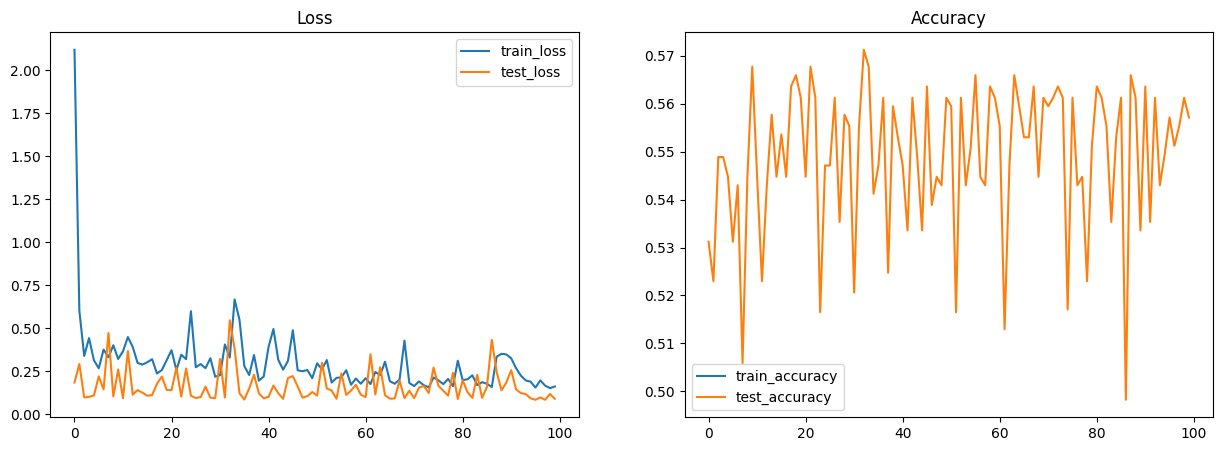

Evaluation Metrics: 
Mean_precision: 10.882429122924805
Mean_recall: 10.309303283691406
Mean_accuracy: 0.5489869713783264


In [ ]:
batch_size = 32
epochs = 100

metrics_history = {
    "train_loss": [],
    "train_accuracy": [],
    "test_loss": [],
    "test_accuracy": [],
    "test_recall": [],
    "test_precision": []
}

train_ds = train_dataset.shuffle(1000).batch(batch_size)
test_ds = test_dataset.batch(batch_size)

train(epochs, params, model, optimizer, opt_state, loss_grad_fn, loss_func, train_ds, test_ds, metrics_history)


print("Evaluation Metrics: ")
print(f"Mean_precision: {sum(metrics_history["test_precision"])/len(metrics_history["test_precision"])}")
print(f"Mean_recall: {sum(metrics_history["test_recall"])/len(metrics_history["test_recall"])}")
print(f"Mean_accuracy: {sum(metrics_history["test_accuracy"])/len(metrics_history["test_accuracy"])}")

❓ Question: What do you expect would happen if we train the model with a very tiny data size e.g one batch of our dataset.

<details>
<summary>✅ Answer</summary>

The model will likely overfit.

With so little data, the model can easily memorize the few examples it sees. This means it may perform well (even perfectly) on the training batch but poorly on unseen data. You'll often see low training loss and very low accuracy on the test set.

On the positive side, training on one batch is a great debugging trick:
It helps check that your model can at least memorize the training data.
If it can't fit even a single batch, something is likely wrong with your setup (loss function, optimizer, data shape, etc.).
</details>

❓ Question: What does it mean if our model has an accuracy of 50%?

<details>
<summary>✅ Answer</summary>

Your model is guessing randomly
In a binary classification task (e.g., predicting 0 or 1), 50% accuracy often indicates the model is no better than random chance like flipping a coin. This is especially true if the dataset is balanced, meaning there are roughly equal numbers of class 0 and class 1 examples.
</details>

Play around with the hyperparameters of the model and see if you can improve the accuracy of the model.

## Multiclass Classifier


So far, we've built a **binary classifier** i.e a model that distinguishes between two categories, like "pass" or "fail."

But in many real-world applications, we need to predict one of **several categories**.

#### Real-World Examples of Multiclass Classification:
- 🐶 Recognizing the breed of a dog  
- 📧 Classifying an email as "primary", "promotions", or "spam"  

These are all **multiclass classification** problems.


In this section. We'll work with the **MNIST dataset**, a classic benchmark in machine learning. It contains grayscale images of handwritten digits from **0 to 9**.

Our goal is to train a neural network that takes an image as input and predicts the digit it represents.

✅ **Output Classes**: 10 (digits 0–9)  
✅ **Input Shape**: 28 × 28 pixels (flattened to 784)


 🔧 What Needs to Change from the Binary Classifier?

#### 1. Output Layer

In binary classification:
- We had **1 output neuron** to represent the probability of class 1.

In multiclass classification:
- We need **1 output neuron per class**.
- For MNIST, this means the output should be a **vector of size 10**.

Mathematically, for an input \\( x \\), the model outputs a vector of scores (logits):

$$
\mathbf{z} = \begin{bmatrix}
z_0, z_1, \dots, z_9
\end{bmatrix}
$$

#### 2. Output Activation Function: From **Sigmoid** to **Softmax**

- In binary classification, we used the **sigmoid** function to get a value between 0 and 1.
- But applying sigmoid to each of the 10 logits **does not ensure** they sum to 1.

We want a **valid probability distribution** where:

$$
\sum_{i=0}^{9} p_i = 1
$$


To do this, we use the **softmax** function, which converts raw scores (logits) into probabilities:

$$
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=0}^{9} e^{z_j}}
$$

This ensures:
- All output values are **positive**
- They **sum to 1**

#### 3. Loss Function: Cross Entropy (Extended)

Since we are still predicting probabilities, we will continue using the **cross-entropy loss** but slightly adjusted for multiple classes.

In binary classification:

$$
L_{CE}(\hat{y}, y) = - \left[ y \log \hat{y} + (1 - y) \log(1 - \hat{y}) \right]
$$


In multiclass classification, using integer labels $y \in \{0, \dots, 9\}$ and predicted probabilities $\hat{y}_i$ , the loss becomes:

$$
L_{CE}(\hat{\mathbf{y}}, y) = - \log(\hat{y}_{y})
$$

This picks the log probability of the correct class and penalizes the model if it assigns it a low probability.


#### What’s Next?

In the cells below, we'll:
- Modify our binary classifier to accept 28×28 input images
- Replace the output activation with **softmax**
- Use **cross-entropy loss** for multiclass classification
- Train the model on the **MNIST** dataset

### Load MNIST Dataset


We’ll use TensorFlow Datasets (TFDS) to load the MNIST dataset. TFDS makes it easy to access standard datasets with minimal setup.

Each image in MNIST is:

- A grayscale image of size 28×28

- We'll flatten each image into a 784-dimensional vector so it can be passed into a fully connected MLP.

The labels are integers from 0 to 9, representing the digit in the image.

In summary we'll:

- Load the MNIST dataset using tfds.load.

- Flatten the images from shape (28, 28) to (784,).

- Convert the TensorFlow tensors to NumPy arrays for compatibility with JAX.

- One-hot encode the labels (optional but often used for multiclass classification).

In [ ]:
batch_size = 32
train_steps = 1200

# Example using TFDS to load MNIST
import tensorflow_datasets as tfds

ds = tfds.load('mnist', split='train', as_supervised=True)
ds = ds.map(lambda img, label: (tf.cast(tf.reshape(img, [-1]), tf.float32) / 255.0, label))

# Split into train and test
ds_train = ds.take(50000)
ds_test = ds.skip(50000)

### Modify Binary MLP

💻 Code Task: Modify the MLP for Multiclass Classification (MNIST)

1. Modify the `input_size` to be the number of features in the input

2. Modify the `output_size` to be the number of classes in the dataset.


In [ ]:
seed = 32
input_size = 784
hidden_size_1 = 60
hidden_size_2 = 60
hidden_size_3 = 30
output_size = 10

multi_class_model = MLP(hidden_size_1, hidden_size_2, hidden_size_3, output_size)

key = jax.random.PRNGKey(seed)

dummy_data = jnp.zeros((1, input_size), dtype=float)


multi_class_params = multi_class_model.init(key, dummy_data)

# Print model parameters
print_param_shapes(multi_class_params['params'])

Dense_0/kernel: shape=(784, 60)
Dense_0/bias: shape=(60,)
Dense_1/kernel: shape=(60, 60)
Dense_1/bias: shape=(60,)
Dense_2/kernel: shape=(60, 30)
Dense_2/bias: shape=(30,)
Dense_3/kernel: shape=(30, 10)
Dense_3/bias: shape=(10,)


In [ ]:
# @title 🔓Solution - Model initialisation (Try not to peek until you've given it a good try!')
seed = 32
input_size = 784
hidden_size_1 = 60
hidden_size_2 = 60
hidden_size_3 = 30
output_size = 10

multi_class_model = MLP(hidden_size_1, hidden_size_2, hidden_size_3, output_size)

key = jax.random.PRNGKey(seed)

dummy_data = jnp.zeros((1, input_size), dtype=float)


multi_class_params = model.init(key, dummy_data)

# Print model parameters
print_param_shapes(multi_class_params['params'])

### Softmax Cross Entropy Loss

In multiclass classification, we use **softmax cross-entropy loss**. This computes the probability of each class and penalizes wrong predictions.

We'll use `optax.softmax_cross_entropy_with_integer_labels` which expects:
- Logits of shape `(batch_size, num_classes)`
- Integer labels (not one-hot) of shape `(batch_size,)`


💻 **Code Task: Implement the Loss Function for Multiclass Classification**

Now that we’ve modified our model to output 10 logits (one for each class), we need a loss function that compares these predictions to the true labels (integers from 0–9) and helps our model learn.

We’ll use cross-entropy loss the most common loss function for classification tasks. We'll use `optax.softmax_cross_entropy_with_integer_labels` a utility that takes:

- logits: model predictions (before softmax)

- labels: integer class labels (e.g. 3, 7, 0...)

It:

- Internally applies softmax to logits.

- Computes the negative log likelihood.

- Returns the loss per sample (which we average).


Complete the function `loss_fn` which takes in:

- model: a Flax model that outputs raw logits

- model parameters `params`

- batch: a tuple (x, y) where:

  - x is the input (e.g. flattened MNIST images, shape [batch_size, 784])

  - y is the target label (e.g. integers 0–9, shape [batch_size])

Return:

- The mean loss across the batch

- The logits from the model

In [ ]:
import optax

def loss_func(params, model, batch):
    """
    Computes the average softmax cross-entropy loss for a batch.
    """
    x, y = batch  # x: [batch_size, 784], y: [batch_size]

    # Call the model on the input
    logits =   # shape: [batch_size, 10]

    # Compute the softmax cross-entropy loss
    loss = ...  # replace this line

    return loss, logits


In [ ]:
# @title 🔓Solution - loss_fn (Try not to peek until you've given it a good try!')
import optax
def loss_func(params, model, batch):
  x, y = batch
  logits = model.apply(params, x)
  loss = optax.softmax_cross_entropy_with_integer_labels(logits, y).mean()
  return loss, logits

We'll wrap the loss_fn in `jax.value_and_grad` like we did for the binary classifier

In [ ]:
loss_grad_fn = jax.value_and_grad(loss_func, has_aux=True)

In [ ]:
learning_rate = 0.001

optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(multi_class_params)

In [ ]:
@struct.dataclass
class TrainMetrics(metrics.Collection):
  loss: metrics.Average.from_output('loss')

@struct.dataclass
class EvalMetrics(metrics.Collection):
  accuracy: metrics.Accuracy
  loss: metrics.Average.from_output('loss')

In [ ]:
batch_size = 32
epochs = 100

metrics_history = {
    "train_loss": [],
    "train_accuracy": [],
    "test_loss": [],
    "test_accuracy": [],
    "test_recall": [],
    "test_precision": []
}

train_ds = ds_train.shuffle(1000).batch(batch_size)
test_ds = ds_test.batch(batch_size)


train(epochs, multi_class_params, multi_class_model, optimizer, opt_state, loss_grad_fn, loss_func, train_ds, test_ds, metrics_history)


print("Evaluation Metrics: ")
print(f"Mean_accuracy: {sum(metrics_history["test_accuracy"])/len(metrics_history["test_accuracy"])}")

## Appendix


#### References
1. Flax module documentation: https://flax-linen.readthedocs.io/en/latest/api_reference/flax.linen/module.html


## Feedback

Please provide feedback that we can use to improve our practicals in the future.

In [ ]:
# @title Generate Feedback Form. (Run Cell)
from IPython.display import HTML

HTML(
    """
<iframe
	src="https://forms.gle/CJCNwwcLW9Y3jZDG7",
  width="80%"
	height="1200px" >
	Loading...
</iframe>
"""
)

<img src="https://baobab.deeplearningindaba.com/static/media/indaba-logo-dark.d5a6196d.png" width="50%" />